In [216]:
import numpy as np
import pylab as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def data_prepare(x,y,data_config,warning=True):
    if y.ndim>1:
        assert 0,'y dim problem!'
    dataset = []
    labels = []
    selects = []
    for k,v in data_config.items():
        filt = y==k
        if v>np.sum(filt):
            if warning:
                v = np.sum(filt)
                assert v!=0,'No data is available!'
                print('WARNING! Requested data is not available, reduce the {} class. The number is reduced to {}!'.format(k,v))
            else:
                assert 0, 'Requested data is not available, reduce the {} class'.format(k)
        
        inds = np.argwhere(filt)[:,0]
        np.random.shuffle(inds)
        selceted = inds[:v]
        dataset.extend(x[selceted])
        labels.extend([k]*v)
        selects.extend(selceted)
    return np.delete(x, selects,axis=0),np.delete(y, selects,axis=0),np.array(dataset),np.array(labels)

# def describe_labels(y0):
#     y = y0+0
#     if y.ndim==2:
#         y = np.argmax(y,axis=1)
#     class_labels, nums = np.unique(y,return_counts=True)
#     n_calss = len(class_labels)
#     print('labels/numbers are:\n',*['{:5s}/{:6d}\n'.format(str(i),j) for i,j in zip(class_labels,nums)])
#     return n_calss

def describe_labels(y0,int_mapper=None,verbose=0):
    y = y0+0
    if y.ndim==2:
        y = np.argmax(y,axis=1)
    class_labels, nums = np.unique(y,return_counts=True)
    n_class = len(class_labels)
    tmp = '\t{:{width}s}/{:6d}\n'
    if verbose:
        print('labels/numbers are:')
        if int_mapper is None:
            ns = 6
    #         print('{:{width}s}/numbers are:'.format('labels',width=ns))
            print(*[tmp.format(str(i),j,width=ns) for i,j in zip(class_labels,nums)])
        else:
            ns = max([len(i) for i in list(int_mapper.values())])+3
    #         print('{:{width}s}/numbers are:'.format('labels',width=ns))
    #         print(tem.format(int_mapper[i],j,width=ns) for i,j in zip(class_labels,nums)])
            print(*[tmp.format(int_mapper[i],j,width=ns) for i,j in zip(class_labels,nums)])
    return n_class,class_labels, nums

def augment(aug,x):
    aug.fit(x)
    out = []
    for i in x:
        out.append(aug.random_transform(i))
    return np.array(out)

def balance_aug(x0,y0,aug=None,mixup=False,reshape=None):
#     assert y0.ndim>1,'Agumentor ndim problem!'
    
    if not reshape is None:
        shape0 = x0.shape
        x = x0.reshape(reshape)
    else:
        x = x0+0
    if y0.ndim==2:
        y = np.argmax(y0,axis=1)
        to_cat = True
    elif y0.ndim==1:
        y = y0+0
        to_cat = False
    else:
        assert 0,'Agumentor y ndim problem!'
        
    class_labels, nums = np.unique(y,return_counts=True)
    nmax = max(nums)
    for i,(lbl,n0) in enumerate(zip(class_labels,nums)):
        if nmax==n0:
            continue
        delta = nmax-n0
        x_sub = x[y==lbl]
        inds = np.arange(n0)
        nrep = (nmax//len(inds))+1
        inds = np.repeat(inds, nrep)
        np.random.shuffle(inds)
        inds = inds[:delta]
        x_sub = x_sub[inds]
        if not aug is None:
            x_sub = augment(aug,x_sub)
            
        if mixup:
            print('MIXUP is not supperted. IGNORED!')
            pass
            
        x = np.concatenate([x,x_sub],axis=0)
        y = np.concatenate([y,delta*[lbl]],axis=0)
        
    if not reshape is None:
        x = x.reshape([-1]+list(shape0)[1:])
    if to_cat:
        y = keras.utils.to_categorical(y)
    return x,y

class DataFeed:
    def __init__(self,x,y,aug = None):
        self.x = x
        self.y = y
        self.aug = aug
        self.nd,self.nx,self.ny,self.ch = x.shape
        self.banance()
        
    def banance(self):
        self.xb,self.yb = balance_aug(self.x,self.y,aug=self.aug)
        self.ndb = self.xb.shape[0]
    def __call__(self,num,reset=False):
        if reset:
            self.banance()
        inds = np.arange(self.ndb)
        np.random.shuffle(inds)
        inds = inds[:num]
        return self.xb[inds],self.yb[inds]

def rws_score(outliers,v,n_o=None):
    outliers = np.array(outliers)
    if n_o is None:
        n_o = int(np.sum(outliers))
    b_s = np.arange(n_o)+1
    o_ind = np.argsort(v)[::-1]
    o_ind = o_ind[:n_o]
    return 1.*np.sum(b_s*outliers[o_ind].reshape(-1))/np.sum(b_s)

INIT_LR = 1e-3

def lr_scheduler(epoch, lr):
    return lr * 0.985

import numpy as np

class MixupGenerator():
    def __init__(self, X_train, y_train, batch_size=32, alpha=0.2, shuffle=True, datagen=None):
        self.X_train = X_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.alpha = alpha
        self.shuffle = shuffle
        self.sample_num = len(X_train)
        self.datagen = datagen

    def __call__(self):
        while True:
            indexes = self.__get_exploration_order()
            itr_num = int(len(indexes) // (self.batch_size * 2))

            for i in range(itr_num):
                batch_ids = indexes[i * self.batch_size * 2:(i + 1) * self.batch_size * 2]
                X, y = self.__data_generation(batch_ids)

                yield X, y

    def __get_exploration_order(self):
        indexes = np.arange(self.sample_num)

        if self.shuffle:
            np.random.shuffle(indexes)

        return indexes

    def __data_generation(self, batch_ids):
        _, h, w, c = self.X_train.shape
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)
        X_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        X1 = self.X_train[batch_ids[:self.batch_size]]
        X2 = self.X_train[batch_ids[self.batch_size:]]
        X = X1 * X_l + X2 * (1 - X_l)

        if self.datagen:
            for i in range(self.batch_size):
                X[i] = self.datagen.random_transform(X[i])
                X[i] = self.datagen.standardize(X[i])

        if isinstance(self.y_train, list):
            y = []

            for y_train_ in self.y_train:
                y1 = y_train_[batch_ids[:self.batch_size]]
                y2 = y_train_[batch_ids[self.batch_size:]]
                y.append(y1 * y_l + y2 * (1 - y_l))
        else:
            y1 = self.y_train[batch_ids[:self.batch_size]]
            y2 = self.y_train[batch_ids[self.batch_size:]]
            y = y1 * y_l + y2 * (1 - y_l)

        return X, y
    
def mixup(x0,y0,alpha,beta,num_classes=None):
    x = x0+0
    y = y0+0
    
    tocat = False
    if y.ndim==1:
        y = keras.utils.to_categorical(y,num_classes=num_classes)
        tocat = True
        print('The labels are converted into categorical')

    class_labels, nums = np.unique(y,return_counts=True)
    # print(class_labels, nums)

    
    nums = np.sum(y,axis=0)

    nmax = max(nums)
    # for i,(lbl,n0) in enumerate(zip(class_labels,nums)):
    for i,n0 in enumerate(nums):

        if nmax==n0 or n0==0:
            continue
        delta = int(nmax-n0)
        
        x_sub = x[y[:,i].astype(bool)]
        y_sub = y[y[:,i].astype(bool)]

        inds = np.arange(n0)
        nrep = (nmax//len(inds))
        inds = np.repeat(inds, nrep)
        np.random.shuffle(inds)
        inds = inds[:delta].astype(int)

        x_sub = x_sub[inds]
        y_sub = y_sub[inds]

        b = np.random.beta(alpha,beta,delta)[:,None]

        inds = np.arange(x.shape[0])
        np.random.shuffle(inds)
        inds = inds[:delta]
        xt = x[inds]
        yt = y[inds]

        if x.ndim==2:
            x_sub = b[:,:]*x_sub+(1-b[:,:])*xt
        elif x.ndim==3:
            x_sub = b[:,:,None]*x_sub+(1-b[:,:,None])*xt
        elif x.ndim==4:
            x_sub = b[:,:,None,None]*x_sub+(1-b[:,:,None,None])*xt
        else:
            assert 0,'The shape is not as expected! {}-{}'.format(x.shape,x_sub.shape)
        
        y_sub = b*y_sub+(1-b)*yt

        x = np.concatenate([x,x_sub],axis=0)
        y = np.concatenate([y,y_sub],axis=0)
#     if tocat:
#         y = np.argmax(y,axis=1)
    return x,y


# callbacks = [
#     LearningRateScheduler(lr_scheduler, verbose=1)
# ]
def build_model(shape,n_class,n_latent = 64):
 
    inp = keras.Input(shape=shape, name="input")
    x = layers.Dense(128, activation="relu")(inp)
    latent = layers.Dense(n_latent, activation="relu")(x)
    dop = layers.Dropout(0.6)(latent)
    out = layers.Dense(n_class, activation="softmax")(dop)
    # out = layers.Dense(n_class, activation="sigmoid")(dop)


    clf = keras.Model(inputs=inp, outputs=out, name="Classifier")
    drt = keras.Model(inputs=inp, outputs=latent, name="DimensionalityReducer")

#     clf.summary()

    clf.compile(
    #     loss=keras.losses.BinaryCrossentropy(),
        loss=keras.losses.CategoricalCrossentropy(),
        optimizer='adam',
        metrics=["accuracy"],
    )
    return clf,drt

def iforest_get_anomalies(z):
    isof = IsolationForest()
    isof.fit(z)
    scores_pred = isof.decision_function(z)
    scores_pred = scores_pred.max()-scores_pred
    return scores_pred

def load_npz(path,verbose=0):
    data = np.load(path)

    x = []
    y = []
    int_mapper = {}
    lbl_mapper = {}

    for i,key in enumerate(list(data)):
        dd = data[key]
        x.extend(dd)
        y.extend(dd.shape[0]*[i])
        int_mapper[i] = key
        lbl_mapper[key] = i
    x = np.array(x)
    y = np.array(y)

    if verbose:
        print(x.shape,y.shape)
        # describe_labels(y,int_mapper=None)
        describe_labels(y,int_mapper=int_mapper,verbose=verbose)

    return x,y,int_mapper,lbl_mapper

class Observetory:
    def __init__(self,plan,x,y):
        self.plan = plan
        self.x = x
        self.y = y
        self.x_obs = np.zeros( [0]+list(self.x.shape[1:]) )
        self.y_obs = np.zeros( [0]+list(self.y.shape[1:]) )
        self.num_obs = 0
        self.n_plan = len(self.plan)
#         self.new_obs()
    def new_obs(self,safemode=False,nightly=False):
        if self.num_obs==self.n_plan:
            if safemode:
#                 print('out of plan!')
                return self.x_obs,self.y_obs
            else:
                assert 0,'No more plan!' 
        data_config = self.plan[self.num_obs]
        self.x,self.y, x_obs, y_obs = data_prepare(self.x,self.y,data_config)
        self.x_obs = np.concatenate([self.x_obs,x_obs],axis=0)
        self.y_obs = np.concatenate([self.y_obs,y_obs],axis=0)
#         print(self.x_obs.shape, self.y_obs.shape, self.x.shape, self.y.shape)
        self.num_obs += 1
        if nightly:
            return x_obs,y_obs
        else:
            return self.x_obs,self.y_obs
    def delete(self,inds):
        self.x_obs = np.delete(self.x_obs,inds,axis=0)
        self.y_obs = np.delete(self.y_obs,inds,axis=0)

BOLD_BEGIN = '\033[1m'
BOLD_END   = '\033[0m' 

In [2]:
# It shows how beta distribution is:
# plt.hist(np.random.beta(20,1,1000))

In [3]:
aug = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.03,
    height_shift_range=0.03,
#     brightness_range=0.01,
#        shear_range=0.0,
    zoom_range=0.03,
#     horizontal_flip=True,
#     vertical_flip=True,
    fill_mode="nearest")

In [4]:
path = '/home/vafaeisa/scratch/datasets/prepared/mnist.npz'
x,y,int_mapper,lbl_mapper = load_npz(path,verbose=1)
x = x/x.max()
n_tot,lx,ly = x.shape
x = x.reshape(n_tot,lx*ly)

noise = 0.1
x += np.random.normal(0,noise,x.shape)
# x = x[:,:,:,None]
n_class,class_labels, nums = describe_labels(y)

plan = [{0:800,1:900,2:0}]+3*[{0:350,1:400,2:15}]
outliers = [2]

print(' ******** Observation begins ******** ')
obs = Observetory(plan,x,y)
x_obs2,y_obs2 = obs.new_obs()
n_class,class_labels, nums = describe_labels(y_obs2,verbose=1)

for _ in range(obs.n_plan+1):
    x_obs,y_obs = obs.new_obs(safemode=1)
    n_class,class_labels, nums = describe_labels(y_obs,verbose=1)

(70000, 28, 28) (70000,)
labels/numbers are:
	class0   /  6903
 	class1   /  7877
 	class2   /  6990
 	class3   /  7141
 	class4   /  6824
 	class5   /  6313
 	class6   /  6876
 	class7   /  7293
 	class8   /  6825
 	class9   /  6958

 ******** Observation begins ******** 
labels/numbers are:
	0.0   /   800
 	1.0   /   900

labels/numbers are:
	0.0   /  1150
 	1.0   /  1300
 	2.0   /    15

labels/numbers are:
	0.0   /  1500
 	1.0   /  1700
 	2.0   /    30

labels/numbers are:
	0.0   /  1850
 	1.0   /  2100
 	2.0   /    45

labels/numbers are:
	0.0   /  1850
 	1.0   /  2100
 	2.0   /    45

labels/numbers are:
	0.0   /  1850
 	1.0   /  2100
 	2.0   /    45



# Anomaly detection using a HUmaN in The loop 

In [114]:
class AHunt:
    def __init__(self,x,y,clf,drt,interest,aug=None):
        self.x = x
        self.n_data = self.x.shape[0]
        self.y = y
        self.clf = clf
        self.n_class = clf.layers[-1].output_shape[-1]
        self.drt = drt
        self.interest = interest
        self.aug = aug
        self.asked_q = []

    def fit(self,
            x=None,
            y=None,
            batch_size=256,
            epochs=10,
            validation_split=0.1,
            verbose=0,
            reshape=None
           ):
        if x is None or y is None:
            x = self.x
            y = self.y
        
#         print(x.shape,y.shape)
        xx,yy = balance_aug(x,y,self.aug,reshape=reshape)
        yy = keras.utils.to_categorical(yy, num_classes=self.n_class)
        history = self.clf.fit(xx, yy,
                               batch_size=batch_size,
                               epochs=epochs,
                               validation_split=validation_split,
                               verbose=verbose)
        return history

    def ask_human(self,x,y,n_questions,minacc=0.0):
        out_obs = y==self.interest
        ano_inds = np.argwhere(out_obs)[:,0]
        z_clf = self.clf.predict(x)
        scr_ano = z_clf[:,self.interest]
        qlist = np.argsort(scr_ano)[::-1]
        inds_all = []
        inds_interest = []
        for q in qlist:
            mn = 10000
            for asked in self.asked_q:
                dist = np.sum( (x[q]-asked)**2 )
                mn = min(mn,dist)
            if mn>minacc:
                inds_all.append(q)
                if q in ano_inds:
                    inds_interest.append(q)
            if len(inds_all)==n_questions: break
        return inds_all,inds_interest
    
    def human_call1(self,x,y,n_questions,minacc=0.0):
#         ano_inds = np.argwhere(out2)[:,0]

        inds_all,inds_interest = self.ask_human(x,y,n_questions,minacc=minacc)
#         [-n_questions:]
#         inds = np.intersect1d(qinds,ano_inds)
        true_guess = len(inds_interest)
        self.asked_q.extend(x[inds_interest])
        self.x = np.concatenate([x[inds_interest],self.x],axis=0)
        self.n_data = self.x.shape[0]
        self.y = np.concatenate([y[inds_interest],self.y],axis=0)
        return true_guess

    def human_call2(self,x,y,n_questions,minacc=0.0):
#         ano_inds = np.argwhere(out2)[:,0]
#         scr_ano = self.predict(x)
#         qinds = np.argsort(scr_ano)[-n_questions:]
#         inds = np.intersect1d(qinds,ano_inds)
        inds_all,inds_interest = self.ask_human(x,y,n_questions,minacc=minacc)
        true_guess = len(inds_interest)
        self.asked_q.extend(x[inds_all])
        self.x = np.concatenate([x[inds_all],self.x],axis=0)
        self.n_data = self.x.shape[0]
        self.y = np.concatenate([y[inds_all],self.y],axis=0)
        return true_guess

    def predict(self,x):
        z_clf = self.clf.predict(x)
        return z_clf[:,self.interest]
    
    def class_predict(self,x):
        return self.clf.predict(x)
    
    def to_latent(self,x):
        z_mu = self.drt.predict(x)
        return z_mu

In [115]:
# clf.layers[1].weights[0].numpy().shape,clf.layers[1].weights[1].numpy().shape

In [116]:
def stds_model(clf):
    ws = []
    bs = []
    for layer in clf.layers:
        if isinstance(layer,layers.Dense):
            ws.append(layer.weights[0].numpy().std())
            bs.append(layer.weights[1].numpy().std())
    return np.array(ws),np.array(bs)
# stds_model(clf)

In [135]:
n_anomaly = 10
trsh = np.sort(scr_ano)[-n_anomaly-1]
y_pred = scr_ano>trsh
np.sum(y_pred)

10

In [217]:
from sklearn.metrics import recall_score,precision_score,classification_report,confusion_matrix,matthews_corrcoef

def compare(path,noise,outlier_ind,pre_data_config,obs_plan,n_questions,n_night=None,nightly=False,epochs=5):
    print(BOLD_BEGIN+'Loaded data configuration:'+BOLD_END)
    x,y,int_mapper,lbl_mapper = load_npz(path,verbose=0)
    x = x/x.max()
    n_tot,lx,ly = x.shape
    x = x.reshape(n_tot,lx*ly)
    if noise!=0:
        x += np.random.normal(0,noise,x.shape)
    n_class,class_labels, nums = describe_labels(y,verbose=0)
#     print(n_class)
    print(BOLD_BEGIN+' ******** previous dataset ******** '+BOLD_END)

    x, y, x_pre, y_pre = data_prepare(x,y,pre_data_config)
    describe_labels(y_pre,verbose=0)
    # x_obs = x_obs_orig.reshape(x_obs_orig.shape[0],-1)
    # y_obs1 = y_obs_orig+0

    print(BOLD_BEGIN+' ******** Observation begins ******** '+BOLD_END)
    obs = Observetory(obs_plan,x,y)

    rws1,rws2,rws3,rws4 = [],[],[],[]
    tg1,tg2,tg3,tg4 = [],[],[],[]
    rc1,rc2,rc3,rc4 = [],[],[],[]
    pr1,pr2,pr3,pr4 = [],[],[],[]
    mcc1,mcc2,mcc3,mcc4 = [],[],[],[]
#     print(n_class)
    clf,drt = build_model(shape=(lx*ly),n_class=n_class,n_latent = 64)
    ahunt = AHunt(x_pre, y_pre,clf,drt,interest=outlier_ind,aug=aug)
    ahunt.fit(reshape=(-1,lx,ly,1))

    clf0,drt0 = build_model(shape=(lx*ly),n_class=n_class,n_latent = 64)
    ahunt0 = AHunt(x_pre, y_pre,clf0,drt0,interest=outlier_ind,aug=aug)
    ahunt0.fit(reshape=(-1,lx,ly,1))

    model_par = []
    model_par.append(stds_model(clf))
    
    if n_night is None: n_night = obs.n_plan
    
    for _ in range(n_night):
        x_obs,y_obs = obs.new_obs(safemode=1,nightly=nightly)
    #     describe_labels(y_obs,verbose=1)

        out_obs = y_obs==outlier_ind
        y_true = out_obs.astype(int)
        n_anomaly = np.sum(out_obs)
        ano_inds = np.argwhere(out_obs)[:,0]

        # Method 1
        
        scr_ano = iforest_get_anomalies(x_obs)
        trsh = np.sort(scr_ano)[-n_anomaly-1]
        y_pred = scr_ano>trsh
        rws = rws_score(out_obs,scr_ano)
        rc = recall_score(y_true,y_pred)
        pr = precision_score(y_true,y_pred)
        mcc = matthews_corrcoef(y_true,y_pred)
        rws1.append(rws)
        rc1.append(rc)
        pr1.append(pr)
        mcc1.append(mcc)
#         assert 0

        qinds = np.argsort(scr_ano)[-n_questions:]
        inds = np.intersect1d(qinds,ano_inds)
        true_guess = len(inds)
        tg1.append(true_guess)
        
        # Method 2
        
        z_mu = ahunt0.to_latent(x_obs)
        scr_ano = iforest_get_anomalies(z_mu)
        trsh = np.sort(scr_ano)[-n_anomaly-1]
        y_pred = scr_ano>trsh
        rws = rws_score(out_obs,scr_ano)
        rc = recall_score(y_true,y_pred)
        pr = precision_score(y_true,y_pred)
        mcc = matthews_corrcoef(y_true,y_pred)
        rws2.append(rws)
        rc2.append(rc)
        pr2.append(pr)
        mcc2.append(mcc)
        
        qinds = np.argsort(scr_ano)[-n_questions:]
        inds = np.intersect1d(qinds,ano_inds)
        true_guess = len(inds)
        tg2.append(true_guess)

        # Method 3
        
        z_mu = ahunt.to_latent(x_obs)
        scr_ano = iforest_get_anomalies(z_mu)
        trsh = np.sort(scr_ano)[-n_anomaly-1]
        y_pred = scr_ano>trsh
        rws = rws_score(out_obs,scr_ano)
        rc = recall_score(y_true,y_pred)
        pr = precision_score(y_true,y_pred)
        mcc = matthews_corrcoef(y_true,y_pred)
        rws3.append(rws)
        rc3.append(rc)
        pr3.append(pr)
        mcc3.append(mcc)

        qinds = np.argsort(scr_ano)[-n_questions:]
        inds = np.intersect1d(qinds,ano_inds)
        true_guess = len(inds)
        tg3.append(true_guess)
        
        # Method 4
#         true_guess = ano_hunt.human_call1(x_obs,y_obs,n_questions)
        true_guess = ahunt.human_call2(x_obs,y_obs,n_questions)
        tg4.append(true_guess)

        ahunt.fit(reshape=(-1,lx,ly,1))
        model_par.append(stds_model(clf))
        scr_ano = ahunt.predict(x_obs)
        trsh = np.sort(scr_ano)[-n_anomaly-1]
        y_pred = scr_ano>trsh
        rws = rws_score(out_obs,scr_ano)
        rc = recall_score(y_true,y_pred)
        pr = precision_score(y_true,y_pred)
        mcc = matthews_corrcoef(y_true,y_pred)
        rws4.append(rws)
        rc4.append(rc)
        pr4.append(pr)
        mcc4.append(mcc)
        
#         print('this',y_true.sum(),y_pred.sum())
#         print(confusion_matrix(y_true, y_pred))
#         print(classification_report(y_true,y_pred))
#     assert 0
    rwss = [rws1,rws2,rws3,rws4]
    tgs = [tg1,tg2,tg3,tg4]
    rcs = [rc1,rc2,rc3,rc4]
    prs = [pr1,pr2,pr3,pr4]
    mccs = [mcc1,mcc2,mcc3,mcc4]
    
    return rwss,tgs,rcs,prs,mccs,model_par

def analyze(xx,cl=2.5):
    m = np.mean(xx,axis=0)
    l = np.percentile(xx,cl,axis=0)
    u = np.percentile(xx,100-cl,axis=0)
    return m,l,u

In [225]:
def planmaker(path,nmin_pre=None,outlier_ind=None):

    data = np.load(path)
    shapes = []
    keys = []
    for key in list(data):
        shapes.append(data[key].shape)
        keys.append(key)
    shapes = np.array(shapes)
    inds_sorted = np.argsort(shapes[:,0])
    outlier_indp = inds_sorted[0]
    
    if outlier_ind is None or outlier_indp==outlier_ind:
        outlier_ind = outlier_indp
        nmin = shapes[inds_sorted[0]][0]//25
        nmaj = shapes[inds_sorted[1]][0]//25
        nmin = min(nmin,nmaj//10)
    else:
        nmin = shapes[inds_sorted[0]][0]//25
        nmaj = shapes[inds_sorted[1]][0]//25
        nmin = min(nmin,nmaj//10)    
    print('outlier is ',keys[outlier_ind])
    if nmin_pre is None:
        nmin_pre = 3*nmin
    pre_data_config = {i:(i==outlier_ind)*nmin_pre+3*(i!=outlier_ind)*nmaj for i in range(len(list(data)))}
    obs_plan = 20*[{i:(i==outlier_ind)*nmin+(i!=outlier_ind)*nmaj for i in range(len(list(data)))}]
    return nmin,outlier_ind,pre_data_config,obs_plan

def run_for(fname,
            epochs = 5,
            noise = 0.0,
            nightly=False,
            ntry = 5,
            n_questions = None,
            outlier_ind = None,
            pre_data_config = None,
            obs_plan = None,
            nmin_pre=None,
            prefix = ''):
    # n_questions = 7
    # pre_data_config = {0:100,1:1}
    # obs_plan = 10*[{0:100,1:10}]
    # outlier_ind = 1
    path = '/home/vafaeisa/scratch/datasets/prepared/{}.npz'.format(fname)

    nmin,outlier_ind0,pre_data_config0,obs_plan0 = planmaker(path,nmin_pre=nmin_pre,outlier_ind=outlier_ind)
    n_questions0 = int(0.7*nmin)
    
    if n_questions is None: n_questions=n_questions0
    if outlier_ind is None: outlier_ind=outlier_ind0
    if pre_data_config is None: pre_data_config=pre_data_config0
    if obs_plan is None: obs_plan=obs_plan0
    print(pre_data_config)
    print(obs_plan[0])

    rws1s,rws2s,rws3s,rws4s = [],[],[],[]
    tg1s,tg2s,tg3s,tg4s  = [],[],[],[]
    rc1s,rc2s,rc3s,rc4s = [],[],[],[]
    pr1s,pr2s,pr3s,pr4s = [],[],[],[]
    mcc1s,mcc2s,mcc3s,mcc4s = [],[],[],[]

    model_pars = []
    for _ in range(ntry):
        res = compare(path = path,
                      noise = noise,
                      outlier_ind = outlier_ind,
                      pre_data_config = pre_data_config,
                      obs_plan = obs_plan,
                      n_questions = n_questions,
                      n_night=30,
                      nightly=nightly,
                      epochs = epochs
                     )

        rwss,tgs,rcs,prs,mccs,model_par = res

        rws1,rws2,rws3,rws4 = rwss
        tg1,tg2,tg3,tg4 = tgs
        rc1,rc2,rc3,rc4 = rcs
        pr1,pr2,pr3,pr4 = prs
        mcc1,mcc2,mcc3,mcc4 = mccs

        rws1s.append(rws1)
        rws2s.append(rws2)
        rws3s.append(rws3)
        rws4s.append(rws4)
        tg1s.append(tg1)
        tg2s.append(tg2)
        tg3s.append(tg3)
        tg4s.append(tg4)
        rc1s.append(rc1)
        rc2s.append(rc2)
        rc3s.append(rc3)
        rc4s.append(rc4)
        pr1s.append(pr1)
        pr2s.append(pr2)
        pr3s.append(pr3)
        pr4s.append(pr4)
        mcc1s.append(mcc1)
        mcc2s.append(mcc2)
        mcc3s.append(mcc3)
        mcc4s.append(mcc4)
        model_pars.append(model_par)

    np.savez('{}{}_res'.format(prefix,fname),
            rws1s = np.array(rws1s),
            rws2s = np.array(rws2s),
            rws3s = np.array(rws3s),
            rws4s = np.array(rws4s),

            tg1s = np.array(tg1s),
            tg2s = np.array(tg2s),
            tg3s = np.array(tg3s),
            tg4s = np.array(tg4s),

            rc1s = np.array(rc1s),
            rc2s = np.array(rc2s),
            rc3s = np.array(rc3s),
            rc4s = np.array(rc4s),

            pr1s = np.array(pr1s),
            pr2s = np.array(pr2s),
            pr3s = np.array(pr3s),
            pr4s = np.array(pr4s),

            mcc1s = np.array(mcc1s),
            mcc2s = np.array(mcc2s),
            mcc3s = np.array(mcc3s),
            mcc4s = np.array(mcc4s),
            model_pars = np.array(model_pars)
           )

    return n_questions
    
def plot_for(fname,n_questions,prefix=''):
    alpha = 0.2
    data = np.load('{}{}_res.npz'.format(prefix,fname))
#     for i in list(data):
#         print(i)
#         exec("{}=np.array(data['{}'])".format(i,i),locals=locals)

    rws1s = data['rws1s']
    rws2s = data['rws2s']
    rws3s = data['rws3s']
    rws4s = data['rws4s']

    tg1s =  data['tg1s']
    tg2s =  data['tg2s']
    tg3s =  data['tg3s']
    tg4s =  data['tg4s']

    rc1s =  data['rc1s']
    rc2s =  data['rc2s']
    rc3s =  data['rc3s']
    rc4s =  data['rc4s']

    pr1s =  data['pr1s']
    pr2s =  data['pr2s']
    pr3s =  data['pr3s']
    pr4s =  data['pr4s']

    mcc1s = data['mcc1s']
    mcc2s = data['mcc2s']
    mcc3s = data['mcc3s']
    mcc4s = data['mcc4s']
    model_pars = data['model_pars']
        
             
#     fig,(ax1,ax2) = plt.subplots(1,2,figsize=(14,5))

#     clrs = ['r','b','g']
#     for i in range(3):
#         clr = clrs[i]

#         m,l,u = analyze(model_pars[:,:,0,i])
#         ax1.plot(m,clr,label='layer='+str(i))
#         ax1.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

#         m,l,u = analyze(model_pars[:,:,1,i])
#         ax2.plot(m,clr,label='layer='+str(i))
#         ax2.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

#     ax1.set_xlabel('night',fontsize=15)
#     ax2.set_xlabel('night',fontsize=15)
#     ax1.set_ylabel('mean weights',fontsize=15)
#     ax2.set_ylabel('mean bias',fontsize=15)
#     ax1.legend(fontsize=13)

#     ax1.set_xlim(0,m.shape[0]-1)
#     # ax1.set_ylim(0,1)
#     ax2.set_xlim(0,m.shape[0]-1)
#     # ax2.set_ylim(0,5.5)

#     plt.subplots_adjust(left=0.05, bottom=0.1, right=0.99, top=0.99, wspace=None, hspace=None)
#     plt.savefig('{}layers_{}.jpg'.format(prefix,fname),dpi=150)
#     plt.close()

             
    fig,axs = plt.subplots(2,2,figsize=(14,10))

    ax = axs[0,0]

    m,l,u = analyze(rws1s)
    clr = 'y'
    ax.plot(m,clr,label='iforest_raw')
    ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

    m,l,u = analyze(rws2s)
    clr = 'r'
    ax.plot(m,clr,label='iforest_latent-static')
    ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

    m,l,u = analyze(rws3s)
    clr = 'g'
    ax.plot(m,clr,label='iforest_latent-learning')
    ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

    m,l,u = analyze(rws4s)
    clr = 'b'
    ax.plot(m,clr,label='AHunt')
    ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

    ax.set_xlabel('night',fontsize=15)
    ax.set_ylabel('RWS',fontsize=15)

    ax.legend(fontsize=13)
    ax.set_xlim(0,m.shape[0]-1)
    ax.set_ylim(0,1)

    ax = axs[0,1]

    m,l,u = analyze(100*tg1s/n_questions)
    clr = 'y'
    ax.plot(m,clr)
    ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

    m,l,u = analyze(100*tg2s/n_questions)
    clr = 'r'
    ax.plot(m,clr)
    ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

    m,l,u = analyze(100*tg3s/n_questions)
    clr = 'g'
    ax.plot(m,clr)
    ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

    m,l,u = analyze(100*tg4s/n_questions)
    clr = 'b'
    ax.plot(m,clr)
    ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

    ax.set_xlabel('night',fontsize=15)
    ax.set_ylabel('True candidates (%)',fontsize=15)

    ax.set_xlim(0,m.shape[0]-1)
    ax.set_ylim(0,102)


    ax = axs[1,0]

    m,l,u = analyze(rc1s)
    clr = 'y'
    ax.plot(m,clr,label='iforest_raw')
    ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

    m,l,u = analyze(rc2s)
    clr = 'r'
    ax.plot(m,clr,label='iforest_latent-static')
    ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

    m,l,u = analyze(rc3s)
    clr = 'g'
    ax.plot(m,clr,label='iforest_latent-learning')
    ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

    m,l,u = analyze(rc4s)
    clr = 'b'
    ax.plot(m,clr,label='AHunt')
    ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

    ax.set_xlabel('night',fontsize=15)
    ax.set_ylabel('recall',fontsize=15)

#     ax.legend(fontsize=13)
    ax.set_xlim(0,m.shape[0]-1)
    ax.set_ylim(0,1)


    ax = axs[1,1]

    # m,l,u = analyze(pr1s)
    # clr = 'y'
    # ax.plot(m,clr,label='iforest_raw')
    # ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

    # m,l,u = analyze(pr2s)
    # clr = 'r'
    # ax.plot(m,clr,label='iforest_latent-static')
    # ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

    # m,l,u = analyze(pr3s)
    # clr = 'g'
    # ax.plot(m,clr,label='iforest_latent-learning')
    # ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

    # m,l,u = analyze(pr4s)
    # clr = 'b'
    # ax.plot(m,clr,label='AnoHunt')
    # ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

    # ax.set_xlabel('night',fontsize=15)
    # ax.set_ylabel('precision',fontsize=15)

    m,l,u = analyze(mcc1s)
    clr = 'y'
    ax.plot(m,clr,label='iforest_raw')
    ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

    m,l,u = analyze(mcc2s)
    clr = 'r'
    ax.plot(m,clr,label='iforest_latent-static')
    ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

    m,l,u = analyze(mcc3s)
    clr = 'g'
    ax.plot(m,clr,label='iforest_latent-learning')
    ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

    m,l,u = analyze(mcc4s)
    clr = 'b'
    ax.plot(m,clr,label='AHunt')
    ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

    ax.set_xlabel('night',fontsize=15)
    ax.set_ylabel('MCC',fontsize=15)

#     ax.legend(fontsize=13)
    ax.set_xlim(0,m.shape[0]-1)
    ax.set_ylim(0,1)


    plt.subplots_adjust(left=0.05, bottom=0.1, right=0.99, top=0.99, wspace=None, hspace=None)
    plt.savefig('{}result_{}.jpg'.format(prefix,fname),dpi=150)

- predict nightly/whole data/

# MNIST

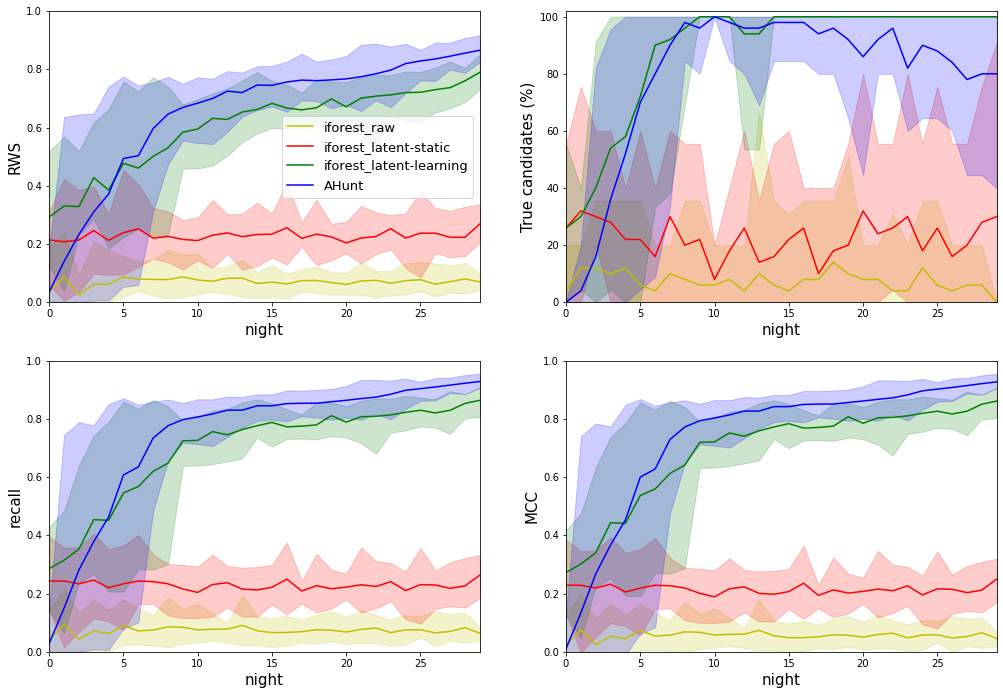

In [226]:
fname = 'mnist'
epochs = 5
noise = 0.1
n_questions = 5
pre_data_config = {0:800,1:900,2:0}
obs_plan = 20*[{0:170,1:200,2:7}]
outlier_ind = 2

n_questions = run_for(fname=fname,
                      epochs = epochs,
                      noise = noise,
                      nightly=False,
                      ntry = 10,
                      n_questions = n_questions,
                      outlier_ind = outlier_ind,
                      pre_data_config = pre_data_config,
                      obs_plan = obs_plan,
                      nmin_pre=None,
                      prefix='figs/all-')
plot_for(fname=fname,n_questions=n_questions,prefix='figs/all-')

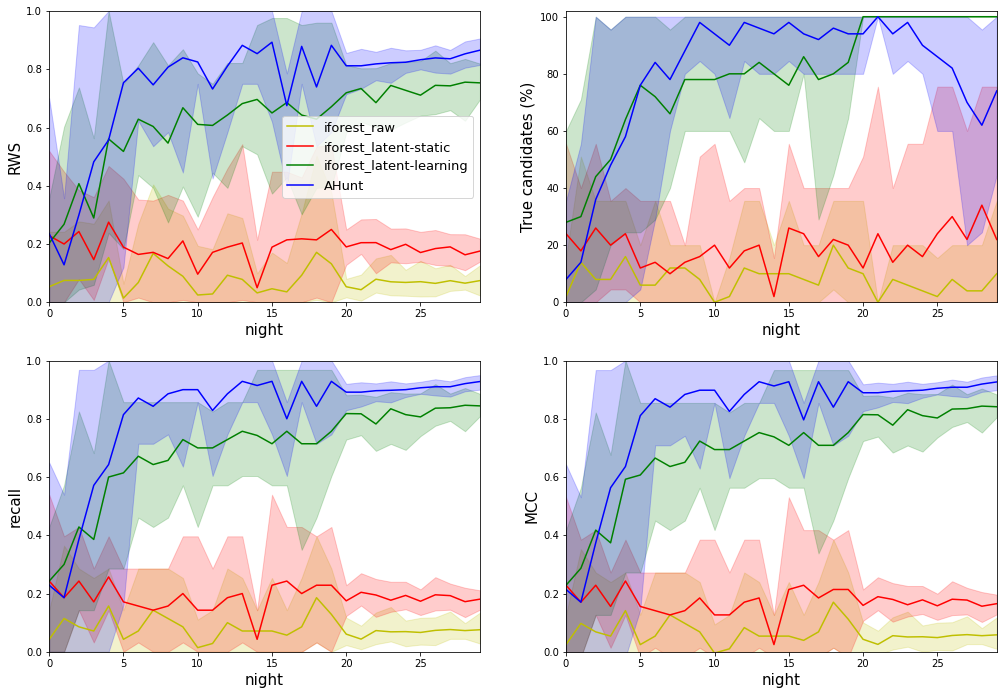

In [228]:
fname = 'mnist'
epochs = 5
noise = 0.1
n_questions = 5
pre_data_config = {0:800,1:900,2:0}
obs_plan = 20*[{0:170,1:200,2:7}]
outlier_ind = 2

n_questions = run_for(fname=fname,
                      epochs = epochs,
                      noise = noise,
                      nightly=True,
                      ntry = 10,
                      n_questions = n_questions,
                      outlier_ind = outlier_ind,
                      pre_data_config = pre_data_config,
                      obs_plan = obs_plan,
                      nmin_pre=None,
                      prefix='figs/nightly-')
plot_for(fname=fname,n_questions=n_questions,prefix='figs/nightly-')

## WTF

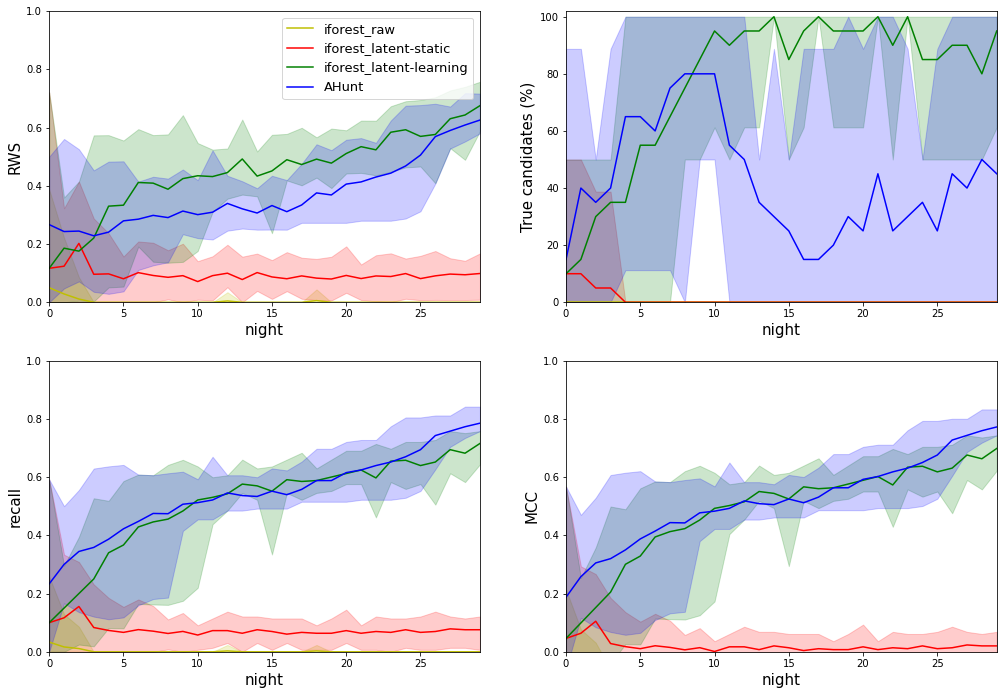

In [229]:
fname = 'wtf'
epochs = 5
noise = 0.0
n_questions = 2
pre_data_config = {0:100,1:0}
obs_plan = 11*[{0:50,1:3}]
outlier_ind = 1

n_questions = run_for(fname=fname,
                      epochs = epochs,
                      noise = noise,
                      nightly=False,
                      ntry = 10,
                      n_questions = n_questions,
                      outlier_ind = outlier_ind,
                      pre_data_config = pre_data_config,
                      obs_plan = obs_plan,
                      nmin_pre=None,
                      prefix='figs/all-')
plot_for(fname=fname,n_questions=n_questions,prefix='figs/all-')

outlier is  interesting
{0: 100, 1: 0}
{0: 50, 1: 3}
Loaded data configuration:
 ******** previous dataset ******** 
 ******** Observation begins ******** 
Loaded data configuration:
 ******** previous dataset ******** 
 ******** Observation begins ******** 
Loaded data configuration:
 ******** previous dataset ******** 
 ******** Observation begins ******** 
Loaded data configuration:
 ******** previous dataset ******** 
 ******** Observation begins ******** 
Loaded data configuration:
 ******** previous dataset ******** 
 ******** Observation begins ******** 
Loaded data configuration:
 ******** previous dataset ******** 
 ******** Observation begins ******** 
Loaded data configuration:
 ******** previous dataset ******** 
 ******** Observation begins ******** 
Loaded data configuration:
 ******** previous dataset ******** 
 ******** Observation begins ******** 
Loaded data configuration:
 ******** previous dataset ******** 
 ******** Observation begins ******** 
Loaded data configur

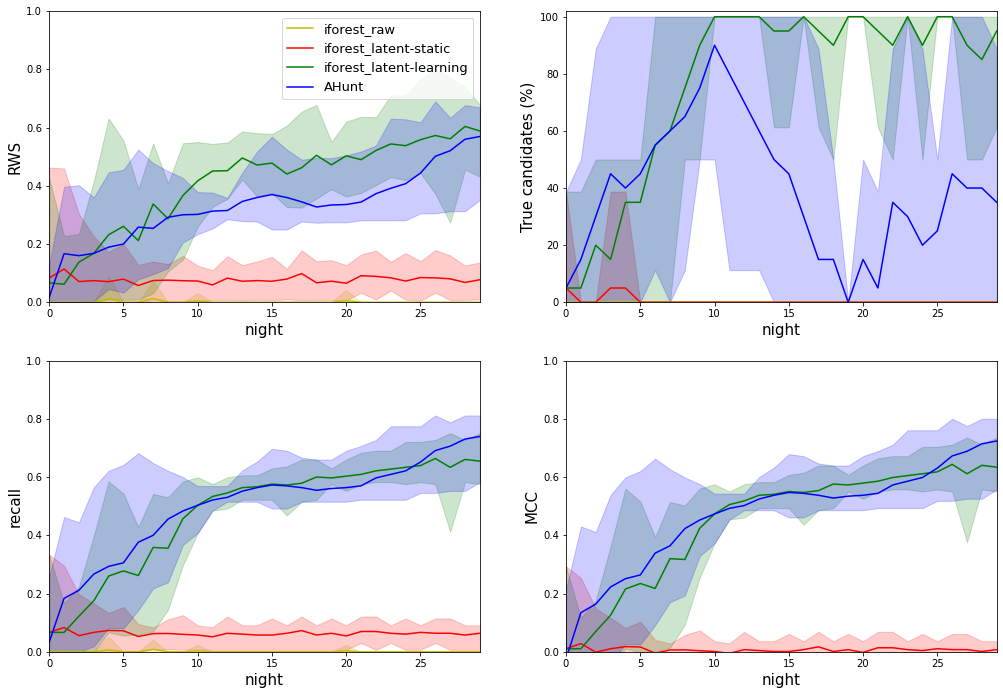

In [231]:
fname = 'wtf'
epochs = 5
noise = 0.0
n_questions = 2
pre_data_config = {0:100,1:0}
obs_plan = 11*[{0:50,1:3}]
outlier_ind = 1

n_questions = run_for(fname=fname,
                      epochs = epochs,
                      noise = noise,
                      nightly=False,
                      ntry = 10,
                      n_questions = n_questions,
                      outlier_ind = outlier_ind,
                      pre_data_config = pre_data_config,
                      obs_plan = obs_plan,
                      nmin_pre=None,
                      prefix='figs/nightly-')
plot_for(fname=fname,n_questions=n_questions,prefix='figs/nightly-')

In [236]:
yt = [1,1,1,1,0,0,0,0,0,0,0,0,0,0,0]
yp = [0,0,1,1,1,1,0,0,0,0,0,0,0,0,0]
recall_score(yt,yp),precision_score(yt,yp),matthews_corrcoef(yt,yp)

(0.5, 0.5, 0.3181818181818182)

In [ ]:
'sarscov2-ctscan_64_64', 'pneumoniamnist'

In [211]:
# epochs = 5
# noise = 0.1
# n_questions = 5
# pre_data_config = {0:800,1:900,2:0}
# obs_plan = 20*[{0:170,1:200,2:7}]
# outlier_ind = 2
# path = '/home/vafaeisa/scratch/datasets/prepared/mnist.npz'

# rws1s,rws2s,rws3s,rws4s = [],[],[],[]
# tg1s,tg2s,tg3s,tg4s  = [],[],[],[]
# rc1s,rc2s,rc3s,rc4s = [],[],[],[]
# pr1s,pr2s,pr3s,pr4s = [],[],[],[]
# mcc1s,mcc2s,mcc3s,mcc4s = [],[],[],[]

# model_pars = []
# for _ in range(10):
#     res = compare(path = path,
#                   noise = noise,
#                   outlier_ind = outlier_ind,
#                   pre_data_config = pre_data_config,
#                   obs_plan = obs_plan,
#                   n_questions = n_questions,
#                   n_night=30,
#                   epochs = epochs
#                  )
    
#     rwss,tgs,rcs,prs,mccs,model_par = res
    
#     rws1,rws2,rws3,rws4 = rwss
#     tg1,tg2,tg3,tg4 = tgs
#     rc1,rc2,rc3,rc4 = rcs
#     pr1,pr2,pr3,pr4 = prs
#     mcc1,mcc2,mcc3,mcc4 = mccs
    
#     rws1s.append(rws1)
#     rws2s.append(rws2)
#     rws3s.append(rws3)
#     rws4s.append(rws4)
#     tg1s.append(tg1)
#     tg2s.append(tg2)
#     tg3s.append(tg3)
#     tg4s.append(tg4)
#     rc1s.append(rc1)
#     rc2s.append(rc2)
#     rc3s.append(rc3)
#     rc4s.append(rc4)
#     pr1s.append(pr1)
#     pr2s.append(pr2)
#     pr3s.append(pr3)
#     pr4s.append(pr4)
#     mcc1s.append(mcc1)
#     mcc2s.append(mcc2)
#     mcc3s.append(mcc3)
#     mcc4s.append(mcc4)
#     model_pars.append(model_par)

# np.savez('{}_res'.format(,
#         rws1s = np.array(rws1s),
#         rws2s = np.array(rws2s),
#         rws3s = np.array(rws3s),
#         rws4s = np.array(rws4s),

#         tg1s = np.array(tg1s),
#         tg2s = np.array(tg2s),
#         tg3s = np.array(tg3s),
#         tg4s = np.array(tg4s),

#         rc1s = np.array(rc1s),
#         rc2s = np.array(rc2s),
#         rc3s = np.array(rc3s),
#         rc4s = np.array(rc4s),

#         pr1s = np.array(pr1s),
#         pr2s = np.array(pr2s),
#         pr3s = np.array(pr3s),
#         pr4s = np.array(pr4s),

#         mcc1s = np.array(mcc1s),
#         mcc2s = np.array(mcc2s),
#         mcc3s = np.array(mcc3s),
#         mcc4s = np.array(mcc4s),
#         model_pars = np.array(model_pars)
#        )

In [213]:
# np.savez('mnist_res',
#         rws1s = np.array(rws1s),
#         rws2s = np.array(rws2s),
#         rws3s = np.array(rws3s),
#         rws4s = np.array(rws4s),

#         tg1s = np.array(tg1s),
#         tg2s = np.array(tg2s),
#         tg3s = np.array(tg3s),
#         tg4s = np.array(tg4s),

#         rc1s = np.array(rc1s),
#         rc2s = np.array(rc2s),
#         rc3s = np.array(rc3s),
#         rc4s = np.array(rc4s),

#         pr1s = np.array(pr1s),
#         pr2s = np.array(pr2s),
#         pr3s = np.array(pr3s),
#         pr4s = np.array(pr4s),

#         mcc1s = np.array(mcc1s),
#         mcc2s = np.array(mcc2s),
#         mcc3s = np.array(mcc3s),
#         mcc4s = np.array(mcc4s),
#         model_pars = np.array(model_pars)
#        )

In [214]:
# data = np.load('mnist_res.npz')
# for i in list(data):
#     print(i)
#     exec("{}=data['{}']".format(i,i))

In [215]:
# alpha = 0.2
# fig,axs = plt.subplots(2,2,figsize=(14,10))

# ax = axs[0,0]

# m,l,u = analyze(rws1s)
# clr = 'y'
# ax.plot(m,clr,label='iforest_raw')
# ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

# m,l,u = analyze(rws2s)
# clr = 'r'
# ax.plot(m,clr,label='iforest_latent-static')
# ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

# m,l,u = analyze(rws3s)
# clr = 'g'
# ax.plot(m,clr,label='iforest_latent-learning')
# ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

# m,l,u = analyze(rws4s)
# clr = 'b'
# ax.plot(m,clr,label='AHunt')
# ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

# ax.set_xlabel('night',fontsize=15)
# ax.set_ylabel('RWS',fontsize=15)

# ax.legend(fontsize=13)
# ax.set_xlim(0,m.shape[0]-1)
# ax.set_ylim(0,1)

# ax = axs[0,1]

# m,l,u = analyze(100*tg1s/n_questions)
# clr = 'y'
# ax.plot(m,clr)
# ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

# m,l,u = analyze(100*tg2s/n_questions)
# clr = 'r'
# ax.plot(m,clr)
# ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

# m,l,u = analyze(100*tg3s/n_questions)
# clr = 'g'
# ax.plot(m,clr)
# ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

# m,l,u = analyze(100*tg4s/n_questions)
# clr = 'b'
# ax.plot(m,clr)
# ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

# ax.set_xlabel('night',fontsize=15)
# ax.set_ylabel('True candidates (%)',fontsize=15)

# ax2.set_xlim(0,m.shape[0]-1)
# ax2.set_ylim(0,102)


# ax = axs[1,0]

# m,l,u = analyze(rc1s)
# clr = 'y'
# ax.plot(m,clr,label='iforest_raw')
# ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

# m,l,u = analyze(rc2s)
# clr = 'r'
# ax.plot(m,clr,label='iforest_latent-static')
# ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

# m,l,u = analyze(rc3s)
# clr = 'g'
# ax.plot(m,clr,label='iforest_latent-learning')
# ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

# m,l,u = analyze(rc4s)
# clr = 'b'
# ax.plot(m,clr,label='AHunt')
# ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

# ax.set_xlabel('night',fontsize=15)
# ax.set_ylabel('recall',fontsize=15)

# ax.legend(fontsize=13)
# ax.set_xlim(0,m.shape[0]-1)
# ax.set_ylim(0,1)


# ax = axs[1,1]

# # m,l,u = analyze(pr1s)
# # clr = 'y'
# # ax.plot(m,clr,label='iforest_raw')
# # ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

# # m,l,u = analyze(pr2s)
# # clr = 'r'
# # ax.plot(m,clr,label='iforest_latent-static')
# # ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

# # m,l,u = analyze(pr3s)
# # clr = 'g'
# # ax.plot(m,clr,label='iforest_latent-learning')
# # ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

# # m,l,u = analyze(pr4s)
# # clr = 'b'
# # ax.plot(m,clr,label='AnoHunt')
# # ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

# # ax.set_xlabel('night',fontsize=15)
# # ax.set_ylabel('precision',fontsize=15)

# m,l,u = analyze(mcc1s)
# clr = 'y'
# ax.plot(m,clr,label='iforest_raw')
# ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

# m,l,u = analyze(mcc2s)
# clr = 'r'
# ax.plot(m,clr,label='iforest_latent-static')
# ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

# m,l,u = analyze(mcc3s)
# clr = 'g'
# ax.plot(m,clr,label='iforest_latent-learning')
# ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

# m,l,u = analyze(mcc4s)
# clr = 'b'
# ax.plot(m,clr,label='AHunt')
# ax.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

# ax.set_xlabel('night',fontsize=15)
# ax.set_ylabel('MCC',fontsize=15)

# ax.legend(fontsize=13)
# ax.set_xlim(0,m.shape[0]-1)
# ax.set_ylim(0,1)


# plt.subplots_adjust(left=0.05, bottom=0.1, right=0.99, top=0.99, wspace=None, hspace=None)
# plt.savefig('result.jpg',dpi=150)

In [61]:
# alpha = 0.2

# model_pars = np.array(model_pars)

# data = np.load('mnist_res.npz')
# for i in list(data):
#     print(i)
#     exec("{}=data['{}']".format(i,i))

# fig,(ax1,ax2) = plt.subplots(1,2,figsize=(14,5))

# clrs = ['r','b','g']
# for i in range(3):
#     clr = clrs[i]

#     m,l,u = analyze(model_pars[:,:,0,i])
#     ax1.plot(m,clr,label='layer='+str(i))
#     ax1.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

#     m,l,u = analyze(model_pars[:,:,1,i])
#     ax2.plot(m,clr,label='layer='+str(i))
#     ax2.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)
             
# ax1.set_xlabel('night',fontsize=15)
# ax2.set_xlabel('night',fontsize=15)
# ax1.set_ylabel('mean weights',fontsize=15)
# ax2.set_ylabel('mean bias',fontsize=15)
# ax1.legend(fontsize=13)

# ax1.set_xlim(0,m.shape[0]-1)
# # ax1.set_ylim(0,1)
# ax2.set_xlim(0,m.shape[0]-1)
# # ax2.set_ylim(0,5.5)

# plt.subplots_adjust(left=0.05, bottom=0.1, right=0.99, top=0.99, wspace=None, hspace=None)
# plt.savefig('layers.jpg',dpi=150)

In [39]:
# plt.plot(model_pars)

# WTF

In [123]:
# epochs = 10
# noise = 0.0
# n_questions = 2
# pre_data_config = {0:100,1:0}
# obs_plan = 11*[{0:50,1:3}]
# outlier_ind = 1
# path = '/home/vafaeisa/scratch/datasets/prepared/wtf.npz'
# n_night=30

# print(BOLD_BEGIN+'Loaded data configuration:'+BOLD_END)
# x,y,int_mapper,lbl_mapper = load_npz(path,verbose=1)
# x = x/x.max()
# n_tot,lx,ly = x.shape
# x = x.reshape(n_tot,lx*ly)
# if noise!=0:
#     x += np.random.normal(0,noise,x.shape)
# n_class,class_labels, nums = describe_labels(y,verbose=0)
# #     print(n_class)
# print(BOLD_BEGIN+' ******** previous dataset ******** '+BOLD_END)

# x, y, x_pre, y_pre = data_prepare(x,y,pre_data_config)
# describe_labels(y_pre,verbose=1)
# # x_obs = x_obs_orig.reshape(x_obs_orig.shape[0],-1)
# # y_obs1 = y_obs_orig+0

# print(BOLD_BEGIN+' ******** Observation begins ******** '+BOLD_END)
# obs = Observetory(obs_plan,x,y)

# rws1,rws2,rws3,rws4 = [],[],[],[]
# tg1,tg2,tg3,tg4 = [],[],[],[]
# #     print(n_class)
# clf,drt = build_model(shape=(lx*ly),n_class=n_class,n_latent = 64)
# ahunt = AHunt(x_pre, y_pre,clf,drt,interest=outlier_ind,aug=aug)
# ahunt.fit(reshape=(-1,lx,ly,1))

# clf0,drt0 = build_model(shape=(lx*ly),n_class=n_class,n_latent = 64)
# ahunt0 = AHunt(x_pre, y_pre,clf0,drt0,interest=outlier_ind,aug=aug)
# ahunt0.fit(reshape=(-1,lx,ly,1))

# model_par = []
# model_par.append(stds_model(clf))

# if n_night is None: n_night = obs.n_plan

# for _ in range(n_night):
#     x_obs,y_obs = obs.new_obs(safemode=1)
# #     describe_labels(y_obs,verbose=1)

#     out_obs = y_obs==outlier_ind
#     ano_inds = np.argwhere(out_obs)[:,0]

#     # Method 1

#     scr_ano = iforest_get_anomalies(x_obs)
#     rws = rws_score(out_obs,scr_ano)
#     rws1.append(rws)  

#     qinds = np.argsort(scr_ano)[-n_questions:]
#     inds = np.intersect1d(qinds,ano_inds)
#     true_guess = len(inds)
#     tg1.append(true_guess)

#     # Method 2

#     z_mu = ahunt0.to_latent(x_obs)
#     scr_ano = iforest_get_anomalies(z_mu)
#     rws = rws_score(out_obs,scr_ano)
#     rws2.append(rws) 

#     qinds = np.argsort(scr_ano)[-n_questions:]
#     inds = np.intersect1d(qinds,ano_inds)
#     true_guess = len(inds)
#     tg2.append(true_guess)

#     # Method 3

#     z_mu = ahunt.to_latent(x_obs)
#     scr_ano = iforest_get_anomalies(z_mu)
#     rws = rws_score(out_obs,scr_ano)
#     rws3.append(rws) 

#     qinds = np.argsort(scr_ano)[-n_questions:]
#     inds = np.intersect1d(qinds,ano_inds)
#     true_guess = len(inds)
#     tg3.append(true_guess)

#     # Method 4
# #         true_guess = ano_hunt.human_call1(x_obs,ano_inds,n_questions)
#     true_guess = ahunt.human_call2(x_obs,y_obs,ano_inds,n_questions)
#     tg4.append(true_guess)

#     ahunt.fit(reshape=(-1,lx,ly,1))
#     model_par.append(stds_model(clf))
#     scr_ano = ahunt.predict(x_obs)
#     rws = rws_score(out_obs,scr_ano)
#     rws4.append(rws)

# rwss = [rws1,rws2,rws3,rws4]
# tgs = [tg1,tg2,tg3,tg4]

In [124]:
# alpha = 0.2
# fig,(ax1,ax2) = plt.subplots(1,2,figsize=(14,5))

# clr = 'y'
# ax1.plot(rws1,clr,label='iforest_raw')

# clr = 'r'
# ax1.plot(rws2,clr,label='iforest_latent-static')

# clr = 'g'
# ax1.plot(rws3,clr,label='iforest_latent-learning')

# clr = 'b'
# ax1.plot(rws4,clr,label='AnoHunt')

# ax1.set_xlabel('night',fontsize=15)
# ax1.set_ylabel('RWS',fontsize=15)

# clr = 'y'
# ax2.plot(tg1,clr)

# clr = 'r'
# ax2.plot(tg2,clr)

# clr = 'g'
# ax2.plot(tg3,clr)

# clr = 'b'
# ax2.plot(tg4,clr)

# ax2.set_xlabel('night',fontsize=15)
# ax2.set_ylabel('True candidates (%)',fontsize=15)
# ax1.legend(fontsize=13)

# ax1.set_xlim(0,m.shape[0]-1)
# ax1.set_ylim(0,1)
# ax2.set_xlim(0,m.shape[0]-1)
# ax2.set_ylim(0,102)

# plt.subplots_adjust(left=0.05, bottom=0.1, right=0.99, top=0.99, wspace=None, hspace=None)
# plt.savefig('result.jpg',dpi=150)

In [232]:
# from sklearn.metrics import classification_report
# # np.argmax(yp,axis=1)==y_obs
# print(classification_report(y_obs,np.argmax(yp,axis=1)))

In [46]:
# np.load('/home/vafaeisa/scratch/datasets/prepared/wtf.npz')['interesting'].shape

In [288]:
# def compare(path,noise,outlier_ind,pre_data_config,obs_plan,n_questions,epochs):
#     print(BOLD_BEGIN+'Loaded data configuration:'+BOLD_END)
#     x,y,int_mapper,lbl_mapper = load_npz(path,verbose=1)
#     x = x/x.max()
#     n_tot,lx,ly = x.shape
#     x = x.reshape(n_tot,lx*ly)
#     if noise!=0:
#         x += np.random.normal(0,noise,x.shape)
#     n_class,class_labels, nums = describe_labels(y,verbose=0)
# #     print(n_class)
#     print(BOLD_BEGIN+' ******** previous dataset ******** '+BOLD_END)

#     x, y, x_pre, y_pre = data_prepare(x,y,pre_data_config)
#     describe_labels(y_pre,verbose=1)
#     # x_obs = x_obs_orig.reshape(x_obs_orig.shape[0],-1)
#     # y_obs1 = y_obs_orig+0

#     print(BOLD_BEGIN+' ******** Observation begins ******** '+BOLD_END)
#     obs = Observetory(obs_plan,x,y)

#     rws1,rws2,rws3,rws4 = [],[],[],[]
#     true_guesses = []
# #     print(n_class)
#     clf,drt = build_model(shape=(lx*ly),n_class=n_class,n_latent = 64)
#     ano_hunt = AnoHunt(x_pre, y_pre,clf,drt,interest=outlier_ind,aug=aug)
#     ano_hunt.fit(reshape=(-1,lx,ly,1))

#     clf0,drt0 = build_model(shape=(lx*ly),n_class=n_class,n_latent = 64)
#     ano_hunt0 = AnoHunt(x_pre, y_pre,clf0,drt0,interest=outlier_ind,aug=aug)
#     ano_hunt0.fit(reshape=(-1,lx,ly,1))

#     model_par = []
#     model_par.append(stds_model(clf))
    
#     for _ in range(obs.n_plan+10):
#         x_obs,y_obs = obs.new_obs(safemode=1)
#     #     describe_labels(y_obs,verbose=1)

#         out_obs = y_obs==outlier_ind

#         scr_ano = iforest_get_anomalies(x_obs)
#         rws = rws_score(out_obs,scr_ano)
#         rws1.append(rws)  

#         z_mu = ano_hunt0.to_latent(x_obs)
#         scr_ano = iforest_get_anomalies(z_mu)
#         rws = rws_score(out_obs,scr_ano)
#         rws2.append(rws) 

#         z_mu = ano_hunt.to_latent(x_obs)
#         scr_ano = iforest_get_anomalies(z_mu)
#         rws = rws_score(out_obs,scr_ano)
#         rws3.append(rws) 

#         ano_inds = np.argwhere(out_obs)[:,0]
#         true_guess = ano_hunt.human_call(x_obs,ano_inds,n_questions)
#         true_guesses.append(true_guess)

#         ano_hunt.fit(reshape=(-1,lx,ly,1))
#         model_par.append(stds_model(clf))
#         scr_ano = ano_hunt.predict(x_obs)
#         rws = rws_score(out_obs,scr_ano)
#         rws4.append(rws)
    
#     return rws1,rws2,rws3,rws4,true_guesses,model_par

In [125]:
epochs = 5
noise = 0.0
n_questions = 2
pre_data_config = {0:100,1:0}
obs_plan = 11*[{0:50,1:3}]
outlier_ind = 1
path = '/home/vafaeisa/scratch/datasets/prepared/wtf.npz'

rws1s,rws2s,rws3s,rws4s = [],[],[],[]
tg1s,tg2s,tg3s,tg4s  = [],[],[],[]
model_pars = []
for _ in range(10):
    rwss,tgs,model_par = compare(path = path,
                                 noise = noise,
                                 outlier_ind = outlier_ind,
                                 pre_data_config = pre_data_config,
                                 obs_plan = obs_plan,
                                 n_questions = n_questions,
                                 n_night=30,
                                 epochs = epochs
                                )
    
    rws1,rws2,rws3,rws4 = rwss
    tg1,tg2,tg3,tg4 = tgs
    
    rws1s.append(rws1)
    rws2s.append(rws2)
    rws3s.append(rws3)
    rws4s.append(rws4)
    tg1s.append(tg1)
    tg2s.append(tg2)
    tg3s.append(tg3)
    tg4s.append(tg4)
    model_pars.append(model_par)
    

Loaded data configuration:
(708, 64, 64) (708,)
labels/numbers are:
	boring        /   674
 	interesting   /    34

 ******** previous dataset ******** 
labels/numbers are:
	0     /   100

 ******** Observation begins ******** 
Loaded data configuration:
(708, 64, 64) (708,)
labels/numbers are:
	boring        /   674
 	interesting   /    34

 ******** previous dataset ******** 
labels/numbers are:
	0     /   100

 ******** Observation begins ******** 
Loaded data configuration:
(708, 64, 64) (708,)
labels/numbers are:
	boring        /   674
 	interesting   /    34

 ******** previous dataset ******** 
labels/numbers are:
	0     /   100

 ******** Observation begins ******** 
Loaded data configuration:
(708, 64, 64) (708,)
labels/numbers are:
	boring        /   674
 	interesting   /    34

 ******** previous dataset ******** 
labels/numbers are:
	0     /   100

 ******** Observation begins ******** 
Loaded data configuration:
(708, 64, 64) (708,)
labels/numbers are:
	boring        /   6

In [126]:
rws1s = np.array(rws1s)
rws2s = np.array(rws2s)
rws3s = np.array(rws3s)
rws4s = np.array(rws4s)

tg1s = np.array(tg1s)
tg2s = np.array(tg2s)
tg3s = np.array(tg3s)
tg4s = np.array(tg4s)

rws1s.shape,tg1s.shape

((10, 30), (10, 30))

rws1s
rws2s
rws3s
rws4s
true_guesses
model_pars


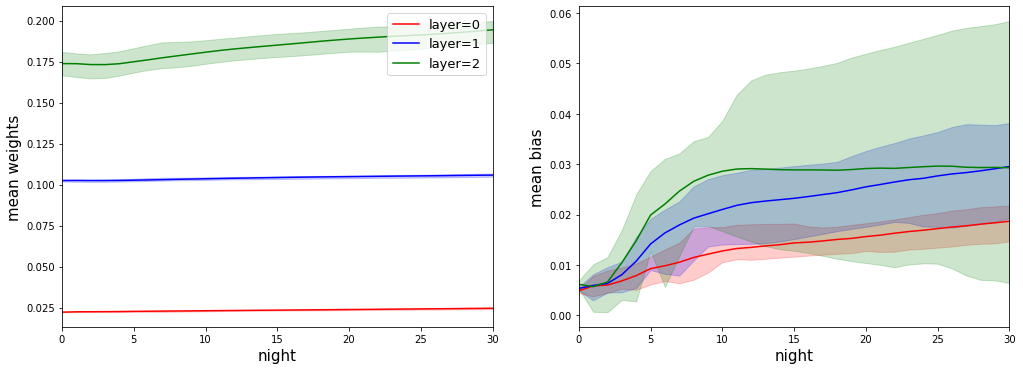

In [127]:
rws1s = np.array(rws1s)
rws2s = np.array(rws2s)
rws3s = np.array(rws3s)
rws4s = np.array(rws4s)
true_guesses = np.array(true_guesses)
model_pars = np.array(model_pars)

np.savez('wtf_res',
        rws1s = rws1s,
        rws2s = rws2s,
        rws3s = rws3s,
        rws4s = rws4s,
        true_guesses = true_guesses,
        model_pars = model_pars
       )


data = np.load('wtf_res.npz')
for i in list(data):
    print(i)
    exec("{}=data['{}']".format(i,i))

model_pars.shape

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(14,5))

clrs = ['r','b','g']
for i in range(3):
    clr = clrs[i]

    m,l,u = analyze(model_pars[:,:,0,i])
    ax1.plot(m,clr,label='layer='+str(i))
    ax1.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

    m,l,u = analyze(model_pars[:,:,1,i])
    ax2.plot(m,clr,label='layer='+str(i))
    ax2.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)
             
ax1.set_xlabel('night',fontsize=15)
ax2.set_xlabel('night',fontsize=15)
ax1.set_ylabel('mean weights',fontsize=15)
ax2.set_ylabel('mean bias',fontsize=15)
ax1.legend(fontsize=13)

ax1.set_xlim(0,m.shape[0]-1)
# ax1.set_ylim(0,1)
ax2.set_xlim(0,m.shape[0]-1)
# ax2.set_ylim(0,5.5)

plt.subplots_adjust(left=0.05, bottom=0.1, right=0.99, top=0.99, wspace=None, hspace=None)
plt.savefig('layers_wtf.jpg',dpi=150)

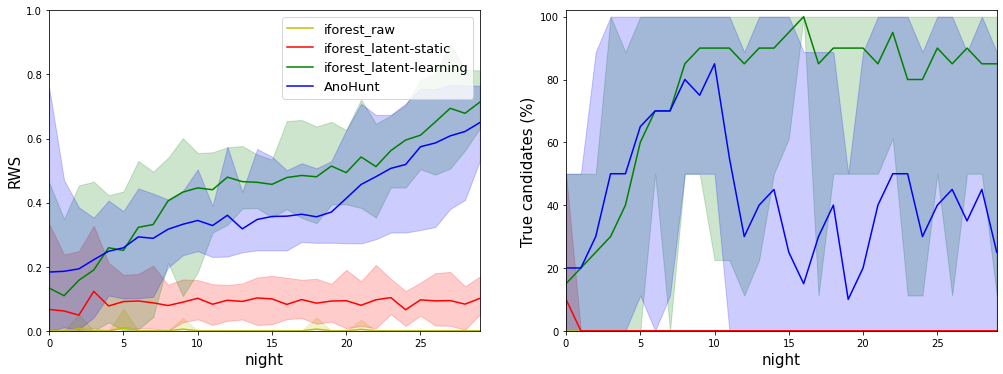

In [128]:
alpha = 0.2
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(14,5))

m,l,u = analyze(rws1s)
clr = 'y'
ax1.plot(m,clr,label='iforest_raw')
ax1.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

m,l,u = analyze(rws2s)
clr = 'r'
ax1.plot(m,clr,label='iforest_latent-static')
ax1.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

m,l,u = analyze(rws3s)
clr = 'g'
ax1.plot(m,clr,label='iforest_latent-learning')
ax1.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

m,l,u = analyze(rws4s)
clr = 'b'
ax1.plot(m,clr,label='AnoHunt')
ax1.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

ax1.set_xlabel('night',fontsize=15)
ax1.set_ylabel('RWS',fontsize=15)


m,l,u = analyze(100*tg1s/n_questions)
clr = 'y'
ax2.plot(m,clr)
ax2.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

m,l,u = analyze(100*tg2s/n_questions)
clr = 'r'
ax2.plot(m,clr)
ax2.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

m,l,u = analyze(100*tg3s/n_questions)
clr = 'g'
ax2.plot(m,clr)
ax2.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

m,l,u = analyze(100*tg4s/n_questions)
clr = 'b'
ax2.plot(m,clr)
ax2.fill_between(np.arange(m.shape[0]),l,u,color=clr,alpha=alpha)

ax2.set_xlabel('night',fontsize=15)
ax2.set_ylabel('True candidates (%)',fontsize=15)
ax1.legend(fontsize=13)

ax1.set_xlim(0,m.shape[0]-1)
ax1.set_ylim(0,1)
ax2.set_xlim(0,m.shape[0]-1)
ax2.set_ylim(0,102)

plt.subplots_adjust(left=0.05, bottom=0.1, right=0.99, top=0.99, wspace=None, hspace=None)
plt.savefig('result_wtf.jpg',dpi=150)

In [130]:
# def compare(path,noise,outlier_ind,pre_data_config,obs_plan,n_questions,epochs):
#     print(BOLD_BEGIN+'Loaded data configuration:'+BOLD_END)
#     x,y,int_mapper,lbl_mapper = load_npz(path,verbose=1)
#     x = x/x.max()
#     n_tot,lx,ly = x.shape
#     x = x.reshape(n_tot,lx*ly)
#     if noise!=0:
#         x += np.random.normal(0,noise,x.shape)
#     n_class,class_labels, nums = describe_labels(y,verbose=0)
# #     print(n_class)
#     print(BOLD_BEGIN+' ******** previous dataset ******** '+BOLD_END)

#     x, y, x_pre, y_pre = data_prepare(x,y,pre_data_config)
#     describe_labels(y_pre,verbose=1)
#     # x_obs = x_obs_orig.reshape(x_obs_orig.shape[0],-1)
#     # y_obs1 = y_obs_orig+0

#     print(BOLD_BEGIN+' ******** Observation begins ******** '+BOLD_END)
#     obs = Observetory(obs_plan,x,y)

#     rws1,rws2,rws3,rws4 = [],[],[],[]
#     true_guesses = []
# #     print(n_class)
#     clf,drt = build_model(shape=(lx*ly),n_class=n_class,n_latent = 64)
#     ano_hunt = AnoHunt(x_pre, y_pre,clf,drt,interest=outlier_ind,aug=aug)
#     ano_hunt.fit(reshape=(-1,lx,ly,1))

#     clf0,drt0 = build_model(shape=(lx*ly),n_class=n_class,n_latent = 64)
#     ano_hunt0 = AnoHunt(x_pre, y_pre,clf0,drt0,interest=outlier_ind,aug=aug)
#     ano_hunt0.fit(reshape=(-1,lx,ly,1))

#     model_par = []
#     model_par.append(stds_model(clf))
    
#     for _ in range(obs.n_plan+10):
#         x_obs,y_obs = obs.new_obs(safemode=1)
#     #     describe_labels(y_obs,verbose=1)

#         out_obs = y_obs==outlier_ind

#         scr_ano = iforest_get_anomalies(x_obs)
#         rws = rws_score(out_obs,scr_ano)
#         rws1.append(rws)  

#         z_mu = ano_hunt0.to_latent(x_obs)
#         scr_ano = iforest_get_anomalies(z_mu)
#         rws = rws_score(out_obs,scr_ano)
#         rws2.append(rws) 

#         z_mu = ano_hunt.to_latent(x_obs)
#         scr_ano = iforest_get_anomalies(z_mu)
#         rws = rws_score(out_obs,scr_ano)
#         rws3.append(rws) 

#         ano_inds = np.argwhere(out_obs)[:,0]
#         true_guess = ano_hunt.human_call(x_obs,ano_inds,n_questions)
#         true_guesses.append(true_guess)

#         ano_hunt.fit(reshape=(-1,lx,ly,1))
#         model_par.append(stds_model(clf))
#         scr_ano = ano_hunt.predict(x_obs)
#         rws = rws_score(out_obs,scr_ano)
#         rws4.append(rws)
    
#     return rws1,rws2,rws3,rws4,true_guesses,model_par

rws1s
rws2s
rws3s
rws4s
true_guesses
model_pars


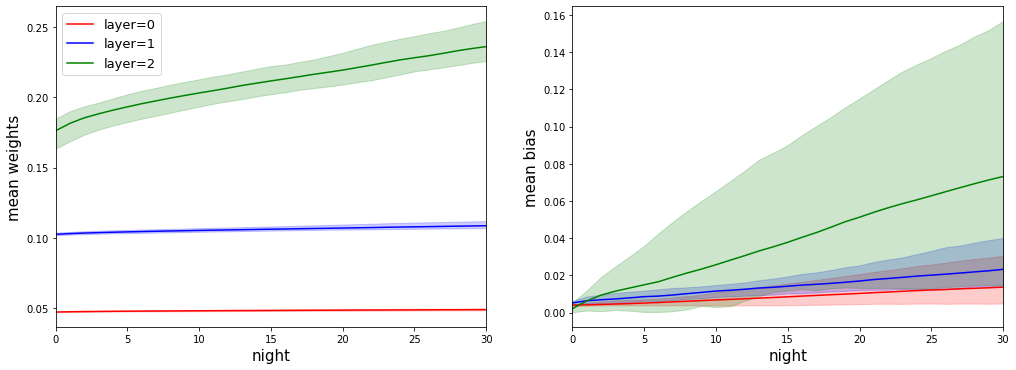

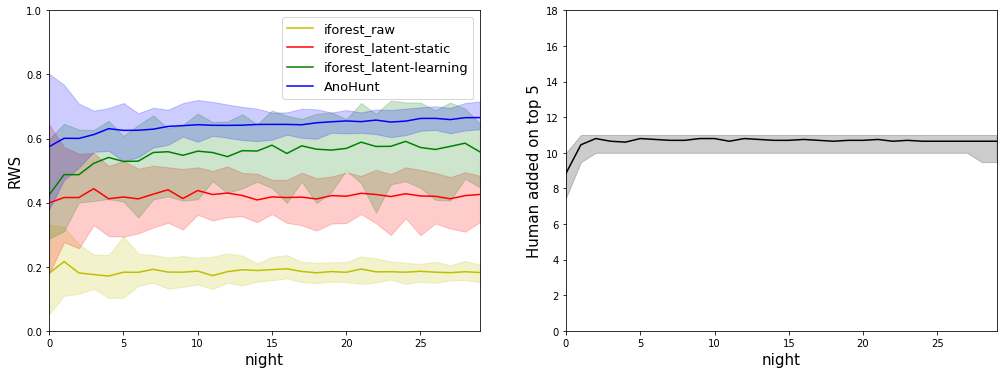

In [336]:
fname = 'pneumoniamnist'
nmin = run_for(fname,epochs = 5,noise = 0.0, nmin_pre=1)
save_for(fname,nmin)

In [339]:
ls /home/vafaeisa/scratch/datasets/prepared/

brain-mri-tumor.npz  Kuzushiji-MNIST.npz      pathmnist.npz
breastmnist.npz      medical-mnist.npz        pneumoniamnist.npz
chestmnist.npz       mnist.npz                retinamnist.npz
cifar10.npz          octmnist.npz             sarscov2-ctscan.npz
dermamnist.npz       organmnist_axial.npz     wtf.npz
fashion_mnist.npz    organmnist_coronal.npz
Kuzushiji-49.npz     organmnist_sagittal.npz


rws1s
rws2s
rws3s
rws4s
true_guesses
model_pars


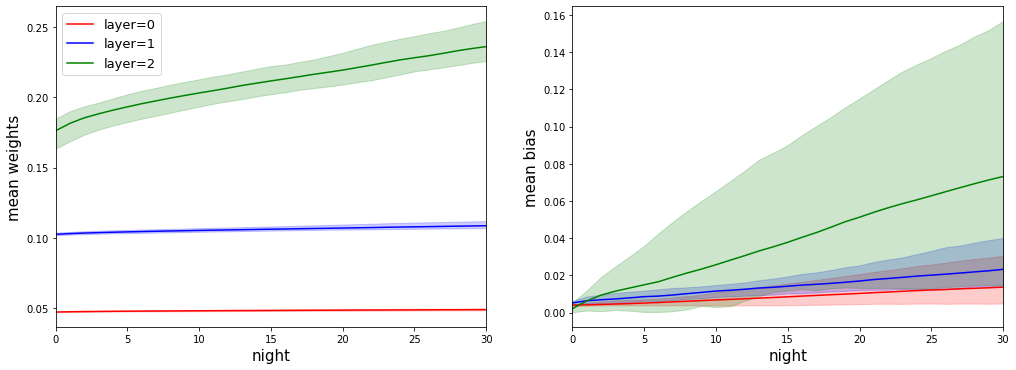

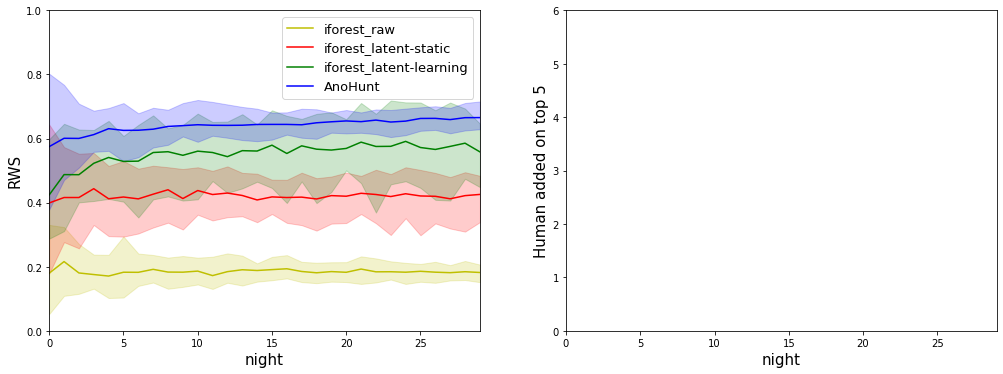

In [383]:
fname = 'sarscov2-ctscan_64_64'
# nmin = run_for(fname,epochs = 5,noise = 0.0, nmin_pre=1, outlier_ind=0)
save_for(fname,nmin)

In [347]:
x,y,int_mapper,lbl_mapper = load_npz(path,verbose=1)
x = x/x.max()

(5856, 28, 28) (5856,)
labels/numbers are:
	class0   /  1583
 	class1   /  4273



In [122]:


rws_nn = []
rpercentile1 = []
rws_if2 = []
true_guess = []
ress = []

obs1_history = []
obs2_history = []
class_labels, nums = np.unique(y_obs1p,return_counts=True)
obs1_history.append([class_labels, nums])

clf,drt = build_model(shape=(28*28),n_class=3,n_latent = 64)

# y_pre_cat = keras.utils.to_categorical(y_pre, num_classes=n_class,)
ano_hunt = AnoHunt(x_pre, y_pre,clf,drt,interest=outlier_ind,aug=aug)

for _ in range(obs.n_plan+10):
    x_obs,y_obs = obs.new_obs(safemode=1)
# #     print('NEW OBS:')
# #     n_class,class_labels, nums = describe_labels(y_obs2)

# #     print(y_obs2.shape)
# #     break
# #     class_labels, nums = np.unique(y_obs2,return_counts=True)

#     x_obs2p = x_obs2.reshape(x_obs2.shape[0],-1)
#     y_obs2p = y_obs2+0
#     out2 = np.isin(y_obs2p,outlier_ind
    
# #     isof = IsolationForest()
# #     isof.fit(x_obs1.reshape(-1,784))
# #     s1 = isof.decision_function(x_obs2p.reshape(-1,784))
# #     s1 = s1.max()-s1
# #     rws = rws_score(out2,s1)
# #     rws_if1.append(rws)
   
# #     isof = IsolationForest()
# #     isof.fit(x_obs2p.reshape(-1,784))
# #     s2 = isof.decision_function(x_obs2p.reshape(-1,784))
# #     s2 = s2.max()-s2
# #     rws = rws_score(out2,s2)
# #     rws_if2.append(rws)


#     ano_hunt.fit(reshape=(-1,lx,ly,1))
#     history = clf.fit(xx, yy, batch_size=256, epochs=epochs, validation_split=0.2,verbose=0)
# #     acc = history.history['accuracy'][-1]

#     z_clf = clf.predict(x_obs2p)
#     scr_ano = z_clf[:,n_class-1]
#     rws = rws_score(out2,scr_ano)

# #     print('acc:{:2.2f}, rws:{:2.2f}'.format(acc,rws))
#     rws_nn.append(rws)

#     # This is where the human act
#     inds = np.intersect1d(np.argsort(scr_ano)[-n_conf:],np.argwhere(out2)[:,0])
#     true_guess.append(len(inds))
#     x_obs1p = np.concatenate([x_obs2p[inds],x_obs1p],axis=0)
#     y_obs1p = np.concatenate([y_obs2p[inds],y_obs1p],axis=0)
    
#     print('HUMAN: {} new outliers are detected!'.format(len(inds)))
#     print('DATASET is extended to:')
#     describe_labels(y_obs1p)
#     ress.append([out2,s1,s2,scr_ano])
# #     print(y_obs1p)

#     x_obs2p = np.delete(x_obs2p,inds,axis=0)
#     y_obs2p = np.delete(y_obs2p,inds,axis=0)
#     obs.delete(inds)

# # fig,(ax1,ax2) = plt.subplots(1,2,figsize=(14,5))
# # ax1.plot(rwss)
# # ax1.set_ylabel('RWS',fontsize=15)
# # ax2.plot(true_guess)
# # ax2.set_ylabel('Human added on top 10',fontsize=15)

Loaded data configuration:
(70000, 28, 28) (70000,)
labels/numbers are:
	class0   /  6903
 	class1   /  7877
 	class2   /  6990
 	class3   /  7141
 	class4   /  6824
 	class5   /  6313
 	class6   /  6876
 	class7   /  7293
 	class8   /  6825
 	class9   /  6958

 ******** previous dataset ******** 
 ******** Observation begins ******** 


IndexError: list index out of range

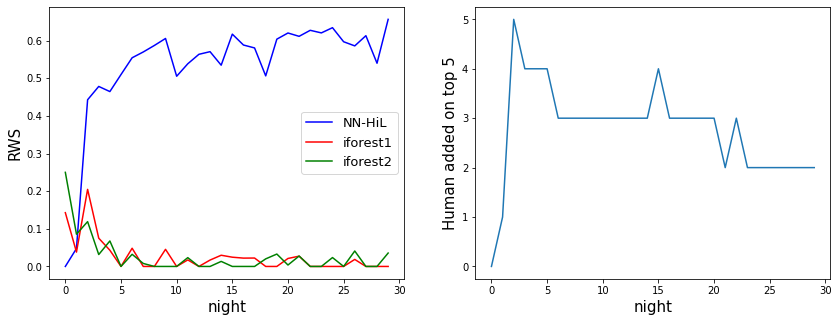

In [57]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(14,5))
ax1.plot(rws_nn,'b',label='NN-HiL')
ax1.plot(rws_if1,'r',label='iforest1')
ax1.plot(rws_if2,'g',label='iforest2')
ax1.set_xlabel('night',fontsize=15)
ax1.set_ylabel('RWS',fontsize=15)
ax2.plot(true_guess)
ax2.set_xlabel('night',fontsize=15)
ax2.set_ylabel('Human added on top {}'.format(n_conf),fontsize=15)
ax1.legend(fontsize=13)
plt.savefig('result.jpg',dpi=150)

In [4]:
noise = 0.5
x += np.random.normal(0,noise,x.shape)
x = x[:,:,:,None]

data_config = {0:800,1:900,2:3}
x_test, y_test, x_obs1, y_obs1 = data_prepare(x_test,y_test,data_config)
print(x_test.shape, y_test.shape,x_obs1.shape, y_obs1.shape)
print()
print()
print(x_train.shape, y_train.shape)
data_config = {0:4000,1:5000,2:200}
x_train, y_train, x_obs2, y_obs2 = data_prepare(x_train,y_train,data_config)
print(x_train.shape, y_train.shape, x_obs2.shape, y_obs2.shape)
outliers = [2]

(10000, 28, 28, 1) (10000,)
(8297, 28, 28, 1) (8297,) (1703, 28, 28, 1) (1703,)


(60000, 28, 28, 1) (60000,)
(50800, 28, 28, 1) (50800,) (9200, 28, 28, 1) (9200,)


In [5]:
# This shows how augmentation and mixup -upsampling work
# x0 = x_obs1+0
# y0 = y_obs1+0
# n_class = describe_labels(y_obs1)
# x,y = balance_aug(x_obs1,y_obs1,aug)
# n_class = describe_labels(y)

# x0 = x_obs1+0
# y0 = y_obs1+0
# alpha = 20
# beta = 1
# n_class = describe_labels(y_obs1)
# x,y = mixup(x_obs1,y_obs1)
# n_class = describe_labels(y)

In [6]:
# df = DataFeed(x_obs1,y_obs1,aug)

In [7]:
# Take look into several samples
# nx = 20
# ny = 5
# fig,axs = plt.subplots(ny,nx,figsize=(nx,ny+2))
# for i in range(ny):
#     for j in range(nx):
# #         img,lbl = df(1)
#         ir = np.random.randint(x.shape[0])
#         img,lbl = x[ir,:,:,0],np.argmax(y[ir])
#         axs[i,j].imshow(img.reshape(28,28),cmap='gray')
#         axs[i,j].set_title(str(lbl),fontsize=15)
#         axs[i,j].set_axis_off()

In [8]:
inlabels = np.setdiff1d(list(data_config.keys()),outliers)

out1 = np.isin(y_obs1,outliers)
out2 = np.isin(y_obs2,outliers)
# labels = np.logical_not(outlires)

### iforest on the raw data (obs1)

In [9]:
xx = x_obs1.reshape(x_obs1.shape[0],-1)
rwss = []
for _ in range(10):
    scores_pred = iforest_get_anomalies(xx)
    rwss.append(rws_score(out1,scores_pred))
print(report_template.format(np.mean(rwss),
                             np.percentile(rwss,5),
                             np.percentile(rwss,95)))

iforest RWS on the raw data is mean 0.00, lower 0.00, upper 0.00


### iforest on the raw data (obs2)

In [10]:
xx = x_obs2.reshape(x_obs2.shape[0],-1)
rwss = []
for _ in range(10):
    scores_pred = iforest_get_anomalies(xx)
    rwss.append(rws_score(out2,scores_pred))
print(report_template.format(np.mean(rwss),
                             np.percentile(rwss,5),
                             np.percentile(rwss,95)))

iforest RWS on the raw data is mean 0.04, lower 0.02, upper 0.07


### now we train a classifier on obs1

You can use either augmentation or mixup

labels/numbers are:
 0    /   800
 1    /   900
 2    /     3

The labels are converted into categorical
labels/numbers are:
 0    /   900
 1    /   900
 2    /   900



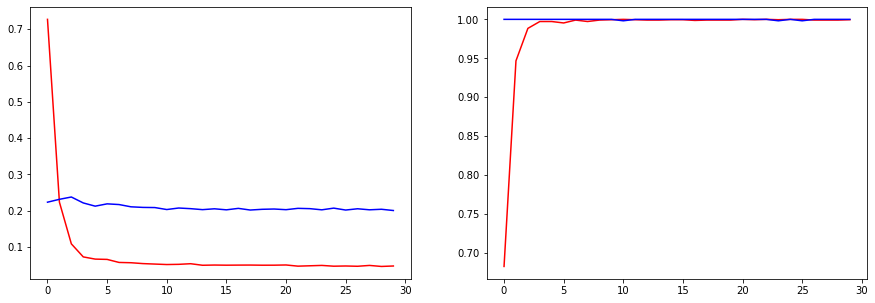

In [11]:
clf,drt = build_model(shape=(28*28),n_class=3,n_latent = 64)

n_class = describe_labels(y_obs1)
# xx,yy = balance_aug(x_obs1,y_obs1,aug)
xx,yy = mixup(x_obs1,y_obs1,alpha=20,beta=1)
n_class = describe_labels(yy)
xx = xx.reshape(xx.shape[0],-1)
# yy = keras.utils.to_categorical(yy, num_classes=n_class,)

history = clf.fit(xx, yy, batch_size=256, epochs=30, validation_split=0.2,verbose=0)
 
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.plot(history.history['loss'],'r')
ax2.plot(history.history['accuracy'],'r')
ax1.plot(history.history['val_loss'],'b')
ax2.plot(history.history['val_accuracy'],'b')

### iforest on the latent space of obs1

In [12]:
xx = x_obs1.reshape(x_obs1.shape[0],-1)
z = drt.predict(xx)
rwss = []
for _ in range(10):
    scores_pred = iforest_get_anomalies(z)
    rwss.append(rws_score(out1,scores_pred))
print(report_template.format(np.mean(rwss),
                             np.percentile(rwss,5),
                             np.percentile(rwss,95)))

iforest RWS on the raw data is mean 1.00, lower 1.00, upper 1.00


### iforest on the latent space of obs2

In [13]:
xx = x_obs2.reshape(x_obs2.shape[0],-1)
z = drt.predict(xx)
rwss = []
for _ in range(10):
    scores_pred = iforest_get_anomalies(z)
    rwss.append(rws_score(out2,scores_pred))
print(report_template.format(np.mean(rwss),
                             np.percentile(rwss,5),
                             np.percentile(rwss,95)))

iforest RWS on the raw data is mean 0.18, lower 0.11, upper 0.24


### or instead of using iforest we can use the third class predicted probability as anomaly score in obs2

In [14]:
xx = x_obs2.reshape(x_obs2.shape[0],-1)
z = clf.predict(xx)

# z = np.argmax(z,axis=1)
# z = np.isin(z,outliers)
z = z[:,n_class-1]

print(rws_score(out2,z))

0.22064676616915424


In [15]:
# confusion_matrix(y_obs2,np.argmax(clf.predict(xx),axis=1))

In [16]:
# n_conf = 5

# # pred = np.round(np.concatenate([z[np.argsort(z)[:n_conf]],z[np.argsort(z)[-n_conf:]]]))
# # truth = np.concatenate([out2[np.argsort(z)[:n_conf]],out2[np.argsort(z)[-n_conf:]]])
# # print('Similarity is {:2.2f}%'.format(np.mean(pred==truth)))
# xx = x_obs2.reshape(x_obs2.shape[0],-1)

# z_clf = clf.predict(xx)
# scr_ano = z_clf[:,n_class-1]
# print(rws_score(out2,scr_ano))

# z_drt = drt.predict(xx)
# scr_ano = iforest_get_anomalies(z_drt)
# print(rws_score(out2,scr_ano))

### we also can use normal/anomaly as labels instead of the real labels

labels/numbers are:
 0    /   800
 1    /   900
 2    /     3

labels/numbers are:
 0    /  1700
 1    /  1700



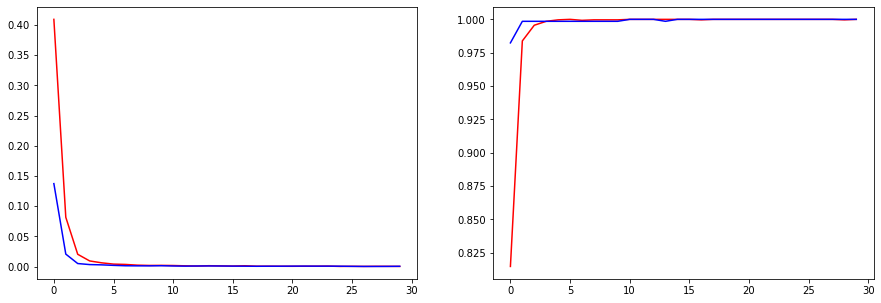

In [17]:
clf,drt = build_model(shape=(28*28),n_class=2,n_latent = 64)

n_class = describe_labels(y_obs1)
xx,yy = balance_aug(x_obs1,out1,aug)
n_class = describe_labels(yy)

xx = xx.reshape(xx.shape[0],-1)
yy = keras.utils.to_categorical(yy)

history = clf.fit(xx, yy, batch_size=256, epochs=30, validation_split=0.2,verbose=0)
 
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.plot(history.history['loss'],'r')
ax2.plot(history.history['accuracy'],'r')
ax1.plot(history.history['val_loss'],'b')
ax2.plot(history.history['val_accuracy'],'b')

In [18]:
xx = x_obs2.reshape(x_obs2.shape[0],-1)
z = clf.predict(xx)
z = z[:,n_class-1]
print(rws_score(out2,z))

0.48771144278606965


In [19]:
# confusion_matrix(out2,np.argmax(clf.predict(xx),axis=1))

the old version of human in the loop:

In [20]:
# n_conf = 5

# pred = np.round(np.concatenate([z[np.argsort(z)[:n_conf]],z[np.argsort(z)[-n_conf:]]]))
# truth = np.concatenate([out2[np.argsort(z)[:n_conf]],out2[np.argsort(z)[-n_conf:]]])
# print('Similarity is {:2.2f}%'.format(np.mean(pred==truth)))

# x1 = x_obs2[np.argsort(z)[:n_conf]]
# x2 = x_obs2[np.argsort(z)[-n_conf:]]
# x_new = np.concatenate([x1,x2],axis=0)
# y_new = np.array(n_conf*[0]+n_conf*[1])
# x_new = np.concatenate([x_obs1,x_new],axis=0)
# y_new = np.concatenate([out1,y_new],axis=0)
# n_class = describe_labels(y_new)
# xx,yy = balance_aug(x_new,y_new,aug)
# n_class = describe_labels(yy)



In [21]:
# xx = xx.reshape(xx.shape[0],-1)
# yy = keras.utils.to_categorical(yy)

# history = clf.fit(xx, yy, batch_size=256, epochs=30, validation_split=0.2,verbose=0)
 
# fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
# ax1.plot(history.history['loss'],'r')
# ax2.plot(history.history['accuracy'],'r')
# ax1.plot(history.history['val_loss'],'b')
# ax2.plot(history.history['val_accuracy'],'b')

In [22]:
# xx = x_obs2.reshape(x_obs2.shape[0],-1)
# z = clf.predict(xx)
# z = z[:,n_class-1]
# print(rws_score(out2,z))

In [23]:
# n_conf = 5

# pred = np.round(np.concatenate([z[np.argsort(z)[:n_conf]],z[np.argsort(z)[-n_conf:]]]))
# truth = np.concatenate([out2[np.argsort(z)[:n_conf]],out2[np.argsort(z)[-n_conf:]]])
# print('Similarity is {:2.2f}%'.format(np.mean(pred==truth)))

# x_old,y_old = x_new+0,y_new+0
# x1 = x_obs2[np.argsort(z)[:n_conf]]
# x2 = x_obs2[np.argsort(z)[-n_conf:]]
# x_new = np.concatenate([x1,x2],axis=0)
# y_new = np.array(n_conf*[0]+n_conf*[1])
# x_new = np.concatenate([x_old,x_new],axis=0)
# y_new = np.concatenate([y_old,y_new],axis=0)
# n_class = describe_labels(y_new)
# xx,yy = balance_aug(x_new,y_new,aug)
# n_class = describe_labels(yy)

# xx = xx.reshape(xx.shape[0],-1)
# yy = keras.utils.to_categorical(yy)

# history = clf.fit(xx, yy, batch_size=256, epochs=30, validation_split=0.2,verbose=0)
 
# fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
# ax1.plot(history.history['loss'],'r')
# ax2.plot(history.history['accuracy'],'r')
# ax1.plot(history.history['val_loss'],'b')
# ax2.plot(history.history['val_accuracy'],'b')

In [24]:
# xx = x_obs2.reshape(x_obs2.shape[0],-1)
# z = clf.predict(xx)
# z = z[:,n_class-1]
# print(rws_score(out2,z))

# Human in the loop (version 2)

### Data prep

In [25]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path="mnist.npz")
n_train = len(x_train)

print(x_test.shape, y_test.shape)
data_config = {0:800,1:900,2:0}

x_test, y_test, x_obs1, y_obs1 = data_prepare(x_test,y_test,data_config)
print(x_test.shape, y_test.shape,x_obs1.shape, y_obs1.shape)
print()
print()
print(x_train.shape, y_train.shape)
data_config = {0:4000,1:5000,2:200}
x_train, y_train, x_obs2, y_obs2 = data_prepare(x_train,y_train,data_config)
print(x_train.shape, y_train.shape, x_obs2.shape, y_obs2.shape)
x_obs1 = x_obs1[:,:,:,None]
x_obs2 = x_obs2[:,:,:,None]

noise = 0.1

x_obs1 = x_obs1/255
x_obs2 = x_obs2/255
x_obs1 += np.random.normal(0,noise,x_obs1.shape)
x_obs2 += np.random.normal(0,noise,x_obs2.shape)
outliers = [2]

n_class = describe_labels(y_obs1)
n_class = describe_labels(y_obs2)

(10000, 28, 28) (10000,)
(8300, 28, 28) (8300,) (1700, 28, 28) (1700,)


(60000, 28, 28) (60000,)
(50800, 28, 28) (50800,) (9200, 28, 28) (9200,)
labels/numbers are:
 0    /   800
 1    /   900

labels/numbers are:
 0    /  4000
 1    /  5000
 2    /   200



# if model keep training

### augmentation

In [26]:
epochs = 2

Text(0, 0.5, 'Human added on top 10')

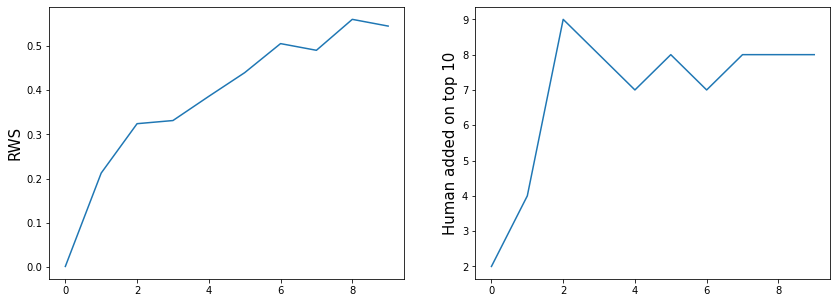

In [27]:
clf,drt = build_model(shape=(28*28),n_class=3,n_latent = 64)

n_conf = 10
x_obs1p = x_obs1.reshape(x_obs1.shape[0],-1)
y_obs1p = y_obs1+0
x_obs2p = x_obs2.reshape(x_obs2.shape[0],-1)
y_obs2p = y_obs2+0

rwss = []
true_guess = []

for _ in range(10):
    x_obs1p = x_obs1p.reshape(-1,28,28,1)
    xx,yy = balance_aug(x_obs1p,y_obs1p,aug)
    x_obs1p = x_obs1p.reshape(-1,784)
    xx = xx.reshape(-1,784)
    yy = keras.utils.to_categorical(yy, num_classes=n_class,)
    history = clf.fit(xx, yy, batch_size=256, epochs=epochs, validation_split=0.2,verbose=0)
    acc = history.history['accuracy'][-1]

    out2 = np.isin(y_obs2p,outliers)
    z_clf = clf.predict(x_obs2p)
    scr_ano = z_clf[:,n_class-1]
    rws = rws_score(out2,scr_ano)

#     print('acc:{:2.2f}, rws:{:2.2f}'.format(acc,rws))
    rwss.append(rws)

    # This is where the human act
    inds = np.intersect1d(np.argsort(scr_ano)[-n_conf:],np.argwhere(out2)[:,0])
    true_guess.append(len(inds))
    x_obs1p = np.concatenate([x_obs2p[inds],x_obs1p],axis=0)
    y_obs1p = np.concatenate([y_obs2p[inds],y_obs1p],axis=0)

    x_obs2p = np.delete(x_obs2p,inds,axis=0)
    y_obs2p = np.delete(y_obs2p,inds,axis=0)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(14,5))
ax1.plot(rwss)
ax1.set_ylabel('RWS',fontsize=15)
ax2.plot(true_guess)
ax2.set_ylabel('Human added on top 10',fontsize=15)

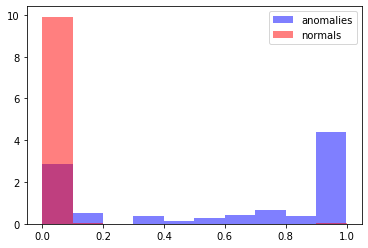

In [28]:
plt.hist(scr_ano[out2],color='b',alpha=0.5,label='anomalies',density=True)
plt.hist(scr_ano[~out2],color='r',alpha=0.5,label='normals',density=True)
plt.legend()

### mixup

The labels are converted into categorical
The labels are converted into categorical
The labels are converted into categorical
The labels are converted into categorical
The labels are converted into categorical
The labels are converted into categorical
The labels are converted into categorical
The labels are converted into categorical
The labels are converted into categorical
The labels are converted into categorical


Text(0, 0.5, 'Human added on top 10')

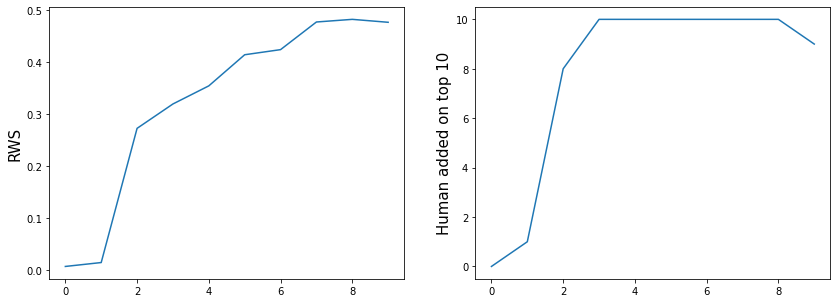

In [29]:
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path="mnist.npz")
# n_train = len(x_train)

# print(x_test.shape, y_test.shape)
# data_config = {0:800,1:900,2:0}

# x_test, y_test, x_obs1, y_obs1 = data_prepare(x_test,y_test,data_config)
# print(x_test.shape, y_test.shape,x_obs1.shape, y_obs1.shape)
# print()
# print()
# print(x_train.shape, y_train.shape)
# data_config = {0:4000,1:5000,2:200}
# x_train, y_train, x_obs2, y_obs2 = data_prepare(x_train,y_train,data_config)
# print(x_train.shape, y_train.shape, x_obs2.shape, y_obs2.shape)
# x_obs1 = x_obs1[:,:,:,None]
# x_obs2 = x_obs2[:,:,:,None]

# noise = 0.1

# x_obs1 = x_obs1/255
# x_obs2 = x_obs2/255
# x_obs1 += np.random.normal(0,noise,x_obs1.shape)
# x_obs2 += np.random.normal(0,noise,x_obs2.shape)
# outliers = [2]

# n_class = describe_labels(y_obs1)
# n_class = describe_labels(y_obs2)

clf,drt = build_model(shape=(28*28),n_class=3,n_latent = 64)

n_conf = 10
x_obs1p = x_obs1.reshape(x_obs1.shape[0],-1)
y_obs1p = y_obs1+0
x_obs2p = x_obs2.reshape(x_obs2.shape[0],-1)
y_obs2p = y_obs2+0

rwss = []
true_guess = []

for _ in range(10):
    xx,yy = mixup(x_obs1p,y_obs1p,alpha=5,beta=1,num_classes=n_class)
    history = clf.fit(xx, yy, batch_size=256, epochs=epochs, validation_split=0.2,verbose=0)
    acc = history.history['accuracy'][-1]

    out2 = np.isin(y_obs2p,outliers)
    z_clf = clf.predict(x_obs2p)
    scr_ano = z_clf[:,n_class-1]
    rws = rws_score(out2,scr_ano)
    rwss.append(rws)

    # This is where the human act
    inds = np.intersect1d(np.argsort(scr_ano)[-n_conf:],np.argwhere(out2)[:,0])
    true_guess.append(len(inds))
    x_obs1p = np.concatenate([x_obs2p[inds],x_obs1p],axis=0)
    y_obs1p = np.concatenate([y_obs2p[inds],y_obs1p],axis=0)

    x_obs2p = np.delete(x_obs2p,inds,axis=0)
    y_obs2p = np.delete(y_obs2p,inds,axis=0)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(14,5))
ax1.plot(rwss)
ax1.set_ylabel('RWS',fontsize=15)
ax2.plot(true_guess)
ax2.set_ylabel('Human added on top 10',fontsize=15)

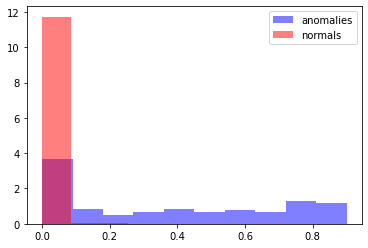

In [30]:
plt.hist(scr_ano[out2],color='b',alpha=0.5,label='anomalies',density=True)
plt.hist(scr_ano[~out2],color='r',alpha=0.5,label='normals',density=True)
plt.legend()

# if model resets everytime

### augmentation

Text(0, 0.5, 'Human added on top 10')

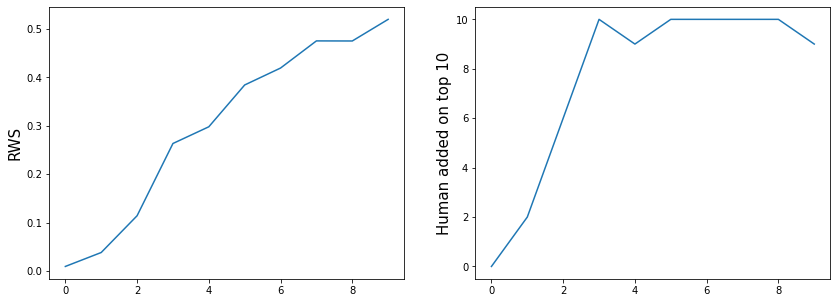

In [31]:
n_conf = 10
x_obs1p = x_obs1.reshape(x_obs1.shape[0],-1)
y_obs1p = y_obs1+0
x_obs2p = x_obs2.reshape(x_obs2.shape[0],-1)
y_obs2p = y_obs2+0

rwss = []
true_guess = []

for _ in range(10):
    x_obs1p = x_obs1p.reshape(-1,28,28,1)
    xx,yy = balance_aug(x_obs1p,y_obs1p,aug)
    x_obs1p = x_obs1p.reshape(-1,784)
    xx = xx.reshape(-1,784)
    yy = keras.utils.to_categorical(yy, num_classes=n_class,)
    clf,drt = build_model(shape=(28*28),n_class=3,n_latent = 64)
    history = clf.fit(xx, yy, batch_size=256, epochs=epochs, validation_split=0.2,verbose=0)
    acc = history.history['accuracy'][-1]

    out2 = np.isin(y_obs2p,outliers)
    z_clf = clf.predict(x_obs2p)
    scr_ano = z_clf[:,n_class-1]
    rws = rws_score(out2,scr_ano)

#     print('acc:{:2.2f}, rws:{:2.2f}'.format(acc,rws))
    rwss.append(rws)

    # This is where the human act
    inds = np.intersect1d(np.argsort(scr_ano)[-n_conf:],np.argwhere(out2)[:,0])
    true_guess.append(len(inds))
    x_obs1p = np.concatenate([x_obs2p[inds],x_obs1p],axis=0)
    y_obs1p = np.concatenate([y_obs2p[inds],y_obs1p],axis=0)

    x_obs2p = np.delete(x_obs2p,inds,axis=0)
    y_obs2p = np.delete(y_obs2p,inds,axis=0)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(14,5))
ax1.plot(rwss)
ax1.set_ylabel('RWS',fontsize=15)
ax2.plot(true_guess)
ax2.set_ylabel('Human added on top 10',fontsize=15)

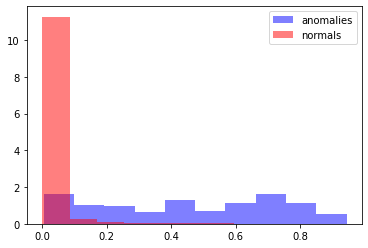

In [32]:
plt.hist(scr_ano[out2],color='b',alpha=0.5,label='anomalies',density=True)
plt.hist(scr_ano[~out2],color='r',alpha=0.5,label='normals',density=True)
plt.legend()

### mixup

The labels are converted into categorical
The labels are converted into categorical
The labels are converted into categorical
The labels are converted into categorical
The labels are converted into categorical
The labels are converted into categorical
The labels are converted into categorical
The labels are converted into categorical
The labels are converted into categorical
The labels are converted into categorical


Text(0, 0.5, 'Human added on top 10')

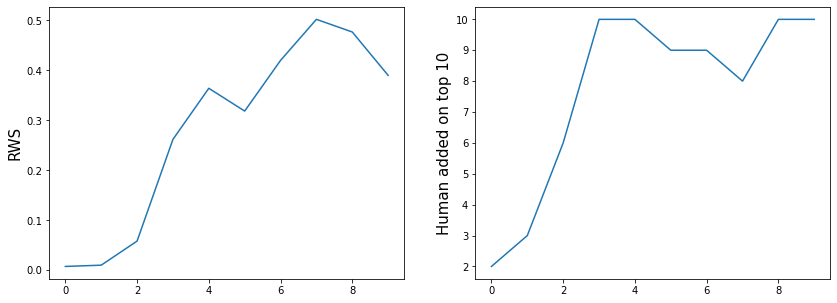

In [33]:
n_conf = 10
x_obs1p = x_obs1.reshape(x_obs1.shape[0],-1)
y_obs1p = y_obs1+0
x_obs2p = x_obs2.reshape(x_obs2.shape[0],-1)
y_obs2p = y_obs2+0

rwss = []
true_guess = []

for _ in range(10):
    xx,yy = mixup(x_obs1p,y_obs1p,alpha=5,beta=1,num_classes=n_class)
    clf,drt = build_model(shape=(28*28),n_class=3,n_latent = 64)
    history = clf.fit(xx, yy, batch_size=256, epochs=epochs, validation_split=0.2,verbose=0)
    acc = history.history['accuracy'][-1]

    out2 = np.isin(y_obs2p,outliers)
    z_clf = clf.predict(x_obs2p)
    scr_ano = z_clf[:,n_class-1]
    rws = rws_score(out2,scr_ano)
    rwss.append(rws)

    # This is where the human act
    inds = np.intersect1d(np.argsort(scr_ano)[-n_conf:],np.argwhere(out2)[:,0])
    true_guess.append(len(inds))
    x_obs1p = np.concatenate([x_obs2p[inds],x_obs1p],axis=0)
    y_obs1p = np.concatenate([y_obs2p[inds],y_obs1p],axis=0)

    x_obs2p = np.delete(x_obs2p,inds,axis=0)
    y_obs2p = np.delete(y_obs2p,inds,axis=0)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(14,5))
ax1.plot(rwss)
ax1.set_ylabel('RWS',fontsize=15)
ax2.plot(true_guess)
ax2.set_ylabel('Human added on top 10',fontsize=15)

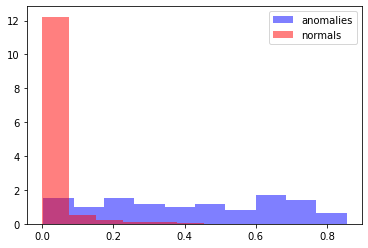

In [34]:
plt.hist(scr_ano[out2],color='b',alpha=0.5,label='anomalies',density=True)
plt.hist(scr_ano[~out2],color='r',alpha=0.5,label='normals',density=True)
plt.legend()

### stream of observation

In [10]:
class Observetory:
    def __init__(self,plan,x,y):
        self.plan = plan
        self.x = x
        self.y = y
        self.x_obs = np.zeros( [0]+list(self.x.shape[1:]) )
        self.y_obs = np.zeros( [0]+list(self.y.shape[1:]) )
        self.num_obs = 0
        self.n_plan = len(self.plan)
#         self.new_obs()
    def new_obs(self,safemode=False):
        if self.num_obs==self.n_plan:
            if safemode:
                print('out of plan!')
                return self.x_obs,self.y_obs
            else:
                assert 0,'No more plan!' 
        data_config = plan[self.num_obs]
        self.x,self.y, x_obs, y_obs = data_prepare(self.x,self.y,data_config)
        self.x_obs = np.concatenate([self.x_obs,x_obs],axis=0)
        self.y_obs = np.concatenate([self.y_obs,y_obs],axis=0)
#         print(self.x_obs.shape, self.y_obs.shape, self.x.shape, self.y.shape)
        self.num_obs += 1
        return self.x_obs,self.y_obs
    def delete(self,inds):
        self.x_obs = np.delete(self.x_obs,inds,axis=0)
        self.y_obs = np.delete(self.y_obs,inds,axis=0)

noise = 0.1
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path="mnist.npz")
n_train = len(x_train)
x_train = x_train/255
x_test = x_test/255
x_train += np.random.normal(0,noise,x_train.shape)
x_test += np.random.normal(0,noise,x_test.shape)
x_train = x_train[:,:,:,None]
x_test = x_test[:,:,:,None]

data_config = {0:800,1:900,2:0}
plan = 3*[{0:350,1:400,2:15}]
outliers = [2]

print(' ******** Our first dataset ******** ')

x_test, y_test, x_obs1, y_obs1 = data_prepare(x_test,y_test,data_config)
n_class = describe_labels(y_obs1)

print(' ******** Observation begins ******** ')
obs = Observetory(plan,x_train,y_train)
x_obs2,y_obs2 = obs.new_obs()
n_class = describe_labels(y_obs2)

for _ in range(obs.n_plan+1):
    x_obs,y_obs = obs.new_obs(safemode=1)
    n_class = describe_labels(y_obs)

 ******** Our first dataset ******** 
labels/numbers are:
 0    /   800
 1    /   900

 ******** Observation begins ******** 
labels/numbers are:
 0.0  /   350
 1.0  /   400
 2.0  /    15

labels/numbers are:
 0.0  /   700
 1.0  /   800
 2.0  /    30

labels/numbers are:
 0.0  /  1050
 1.0  /  1200
 2.0  /    45

out of plan!
labels/numbers are:
 0.0  /  1050
 1.0  /  1200
 2.0  /    45

out of plan!
labels/numbers are:
 0.0  /  1050
 1.0  /  1200
 2.0  /    45



In [11]:
epochs = 5
noise = 0.1
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path="mnist.npz")
n_train = len(x_train)
x_train = x_train/255
x_test = x_test/255
x_train += np.random.normal(0,noise,x_train.shape)
x_test += np.random.normal(0,noise,x_test.shape)
x_train = x_train[:,:,:,None]
x_test = x_test[:,:,:,None]

clf,drt = build_model(shape=(28*28),n_class=3,n_latent = 64)

n_conf = 5

data_config = {0:800,1:900,2:0}
plan = 20*[{0:170,1:200,2:7}]
outliers = [2]

print(' ******** Our first dataset ******** ')

x_test, y_test, x_obs1, y_obs1 = data_prepare(x_test,y_test,data_config)
n_class = describe_labels(y_obs1)
x_obs1p = x_obs1.reshape(x_obs1.shape[0],-1)
y_obs1p = y_obs1+0

print(' ******** Observation begins ******** ')
obs = Observetory(plan,x_train,y_train)

rws_nn = []
rws_if1 = []
rws_if2 = []
true_guess = []
ress = []

for _ in range(obs.n_plan+10):
    x_obs2,y_obs2 = obs.new_obs(safemode=1)
    print('NEW OBS:')
    n_class = describe_labels(y_obs2)

    x_obs2p = x_obs2.reshape(x_obs2.shape[0],-1)
    y_obs2p = y_obs2+0
    out2 = np.isin(y_obs2p,outliers)
    
    isof = IsolationForest()
    isof.fit(x_obs1.reshape(-1,784))
    s1 = isof.decision_function(x_obs2p.reshape(-1,784))
    s1 = s1.max()-s1
    rws = rws_score(out2,s1)
    rws_if1.append(rws)
   
    isof = IsolationForest()
    isof.fit(x_obs2p.reshape(-1,784))
    s2 = isof.decision_function(x_obs2p.reshape(-1,784))
    s2 = s2.max()-s2
    rws = rws_score(out2,s2)
    rws_if2.append(rws)

    x_obs1p = x_obs1p.reshape(-1,28,28,1)
    xx,yy = balance_aug(x_obs1p,y_obs1p,aug)
    x_obs1p = x_obs1p.reshape(-1,784)
    xx = xx.reshape(-1,784)
    yy = keras.utils.to_categorical(yy, num_classes=n_class,)
    history = clf.fit(xx, yy, batch_size=256, epochs=epochs, validation_split=0.2,verbose=0)
#     acc = history.history['accuracy'][-1]

    z_clf = clf.predict(x_obs2p)
    scr_ano = z_clf[:,n_class-1]
    rws = rws_score(out2,scr_ano)

#     print('acc:{:2.2f}, rws:{:2.2f}'.format(acc,rws))
    rws_nn.append(rws)

    # This is where the human act
    inds = np.intersect1d(np.argsort(scr_ano)[-n_conf:],np.argwhere(out2)[:,0])
    true_guess.append(len(inds))
    x_obs1p = np.concatenate([x_obs2p[inds],x_obs1p],axis=0)
    y_obs1p = np.concatenate([y_obs2p[inds],y_obs1p],axis=0)
    
    print('HUMAN: {} new outliers are detected!'.format(len(inds)))
    print('DATASET is extended to:')
    describe_labels(y_obs1p)
    ress.append([out2,s1,s2,scr_ano])
#     print(y_obs1p)

#     x_obs2p = np.delete(x_obs2p,inds,axis=0)
#     y_obs2p = np.delete(y_obs2p,inds,axis=0)
    obs.delete(inds)

# fig,(ax1,ax2) = plt.subplots(1,2,figsize=(14,5))
# ax1.plot(rwss)
# ax1.set_ylabel('RWS',fontsize=15)
# ax2.plot(true_guess)
# ax2.set_ylabel('Human added on top 10',fontsize=15)

 ******** Our first dataset ******** 
labels/numbers are:
 0    /   800
 1    /   900

 ******** Observation begins ******** 
NEW OBS:
labels/numbers are:
 0.0  /   170
 1.0  /   200
 2.0  /     7

HUMAN: 1 new outliers are detected!
DATASET is extended to:
labels/numbers are:
 0.0  /   800
 1.0  /   900
 2.0  /     1

NEW OBS:
labels/numbers are:
 0.0  /   340
 1.0  /   400
 2.0  /    13

HUMAN: 3 new outliers are detected!
DATASET is extended to:
labels/numbers are:
 0.0  /   800
 1.0  /   900
 2.0  /     4

NEW OBS:
labels/numbers are:
 0.0  /   510
 1.0  /   600
 2.0  /    17

HUMAN: 4 new outliers are detected!
DATASET is extended to:
labels/numbers are:
 0.0  /   800
 1.0  /   900
 2.0  /     8

NEW OBS:
labels/numbers are:
 0.0  /   680
 1.0  /   800
 2.0  /    20

HUMAN: 4 new outliers are detected!
DATASET is extended to:
labels/numbers are:
 0.0  /   800
 1.0  /   900
 2.0  /    12

NEW OBS:
labels/numbers are:
 0.0  /   850
 1.0  /  1000
 2.0  /    23

HUMAN: 4 new outliers 

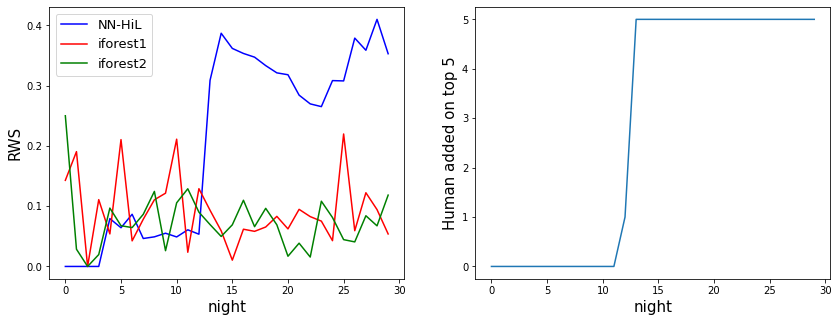

In [9]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(14,5))
ax1.plot(rws_nn,'b',label='NN-HiL')
ax1.plot(rws_if1,'r',label='iforest1')
ax1.plot(rws_if2,'g',label='iforest2')
ax1.set_xlabel('night',fontsize=15)
ax1.set_ylabel('RWS',fontsize=15)
ax2.plot(true_guess)
ax2.set_xlabel('night',fontsize=15)
ax2.set_ylabel('Human added on top {}'.format(n_conf),fontsize=15)
ax1.legend(fontsize=13)
plt.savefig('result.jpg',dpi=150)

# You are entering the under-construction zone!

In [ ]:
x_train = x_train.reshape(-1, 784).astype("float32") / 255


inputs = keras.Input(shape=(784,))
# Just for demonstration purposes.

inp = keras.Input(shape=(28, 28, 1), name="img")
x = layers.Conv2D(16, 3, activation="relu")(inp)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.Conv2D(16, 3, activation="relu")(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

clf = keras.Model(encoder_input, encoder_output, name="encoder")
clf.summary()






model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.RMSprop(),
    metrics=["accuracy"],
)

history = model.fit(x_train, y_train, batch_size=64, epochs=2, validation_split=0.2)

test_scores = model.evaluate(x_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])


In [ ]:
inputs = keras.Input(shape=(784,))
# Just for demonstration purposes.



inp = keras.Input(shape=(28, 28, 1), name="img")
x = layers.Conv2D(16, 3, activation="relu")(inp)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.Conv2D(16, 3, activation="relu")(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name="encoder")
encoder.summary()

x = layers.Reshape((4, 4, 1))(encoder_output)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu")(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation="relu")(x)

autoencoder = keras.Model(encoder_input, decoder_output, name="autoencoder")
autoencoder.summary()
